# Comparing Different GAN Models' Imputation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# Step 1: Load and preprocess metered_data.xlsx
# Load the Excel file containing time series energy usage data
# The file includes columns like datetime, MW readings, year, and month
metered_path = "/content/drive/MyDrive/DeepLearning/GAN/metered_data.xlsx"
metered_df = pd.read_excel(metered_path)

# Remove any columns that are entirely NaN, then fill missing values
# First forward-fill, then backward-fill to handle any edge NaNs
metered_df = metered_df.dropna(axis=1, how='all').ffill().bfill()

# Keep only relevant columns for modeling
metered_df = metered_df[['datetime_beginning_ept', 'mw', 'year', 'month']]

# Convert datetime column to proper datetime objects
metered_df['datetime'] = pd.to_datetime(metered_df['datetime_beginning_ept'])

# Step 2: Normalize MW values using MinMaxScaler
# Initialize MinMaxScaler to scale 'mw' values between 0 and 1
# This helps neural networks train more efficiently
# Returns a scaled NumPy array with the same shape as input
MM_scaler = MinMaxScaler()

#  Step 3: Sequence creator
# Define a function to convert 1D array into overlapping sequences of length 24
# Used for modeling hourly patterns in a daily window (24 hours)
def create_sequences(data, seq_len=24):
    return np.array([data[i:i+seq_len] for i in range(0, len(data) - seq_len, seq_len)])

# Step 4: Prepare training dataset
# Select rows from the years 2022 and 2024 as the training period
metered_train = metered_df[metered_df['year'].isin([2022, 2024])]

# Apply MinMaxScaler to the 'mw' values to normalize them
mw_metered_train = MM_scaler.fit_transform(metered_train[['mw']].values)

# Create sequences of 24 time steps from normalized training data
mw_train_seq = create_sequences(mw_metered_train)

# Save the training sequences as a NumPy file for later use
np.save("/content/x_train_seq.npy", mw_train_seq)

# Step 5: Prepare test datasets by time periods
# Define test cases to evaluate model performance on different time intervals
# Each case represents a different number of months from the year 2023
test_cases = {
    "Jan": [1],                   # January only
    "Jan–Mar": [1, 2, 3],         # First quarter
    "Jan–Jun": [1, 2, 3, 4, 5, 6],# First half of the year
    "FullYear": list(range(1, 13))# All 12 months of 2023
}

# For each test case:
# - Filter the data from 2023 for the specified months
# - Normalize using the same scaler from training
# - Create 24-step sequences
# - Save them for model evaluation
for label, months in test_cases.items():
    df_test = metered_df[(metered_df['year'] == 2023) & (metered_df['month'].isin(months))]
    test_scaled = MM_scaler.transform(df_test[['mw']].values)
    x_test_seq = create_sequences(test_scaled)
    np.save(f"/content/x_test_{label}.npy", x_test_seq)

### Basic GAN Model

In [ ]:
#BasicGAN Training for Imputing Missing Time Series Data
import torch
import torch.nn as nn
from tqdm import trange
import numpy as np  # Required for loading NumPy training sequences

# Basic Generator Definition
# This model receives masked sequences and their masks as input,
# and learns to generate complete sequences.
class BasicGenerator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        # Input: masked + mask (2 * seq_len)
        # Output: reconstructed sequence (seq_len)
        self.fc1 = nn.Linear(seq_len * 2, 128)
        self.fc2 = nn.Linear(128, seq_len)

    def forward(self, masked, mask):
        # Concatenate masked input and its mask
        x = torch.cat([masked, mask], dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

#  Basic Discriminator Definition
# This model classifies sequences as real (original) or fake (generated)
class BasicDiscriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.fc1 = nn.Linear(seq_len, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))  # Outputs probability of being real

# Training Function for BasicGAN
def train_basic_gan(mw_train_seq, epochs=1000, batch_size=64):
    seq_len = mw_train_seq.shape[1]

    # Instantiate models
    generator = BasicGenerator(seq_len)
    discriminator = BasicDiscriminator(seq_len)

    # Optimizers for both networks
    g_opt = torch.optim.Adam(generator.parameters(), lr=0.001)
    d_opt = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # Loss functions: Binary Cross-Entropy for GAN and MSE for reconstruction
    bce = nn.BCELoss()
    mse = nn.MSELoss()

    # Masking function to simulate missing data
    # Randomly drop 40% of the data to create artificial missing values
    def apply_mask(data):
        mask = (np.random.rand(*data.shape) > 0.4).astype(float)
        return data * mask, mask

    # Training loop
    for epoch in range(epochs):
        idx = np.random.permutation(len(mw_train_seq))  # Shuffle data
        pbar = trange(0, len(mw_train_seq), batch_size, desc=f"[BasicGAN] Epoch {epoch+1}/{epochs}", leave=False)

        for i in pbar:
            # Get batch and apply missing value mask
            batch = mw_train_seq[idx[i:i+batch_size]].squeeze(-1)
            masked, mask = apply_mask(batch)

            # Convert to torch tensors
            batch = torch.tensor(batch, dtype=torch.float32)
            masked = torch.tensor(masked, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

            # Labels for real/fake classification
            real_label = torch.ones((len(batch), 1))
            fake_label = torch.zeros((len(batch), 1))

            # Train Discriminator
            fake = generator(masked, mask).detach()  # Generated data (detached to prevent backprop through generator)
            d_real = discriminator(batch)            # Discriminator on real data
            d_fake = discriminator(fake)             # Discriminator on fake data
            d_loss = bce(d_real, real_label) + bce(d_fake, fake_label)
            d_opt.zero_grad(); d_loss.backward(); d_opt.step()

            # Train Generator
            fake = generator(masked, mask)           # Generate new fake data
            d_fake = discriminator(fake)             # Discriminator prediction on fake
            # Generator loss includes adversarial loss + reconstruction MSE (on observed parts)
            g_loss = bce(d_fake, real_label) + mse(fake * mask, batch * mask)
            g_opt.zero_grad(); g_loss.backward(); g_opt.step()

            # Display training progress
            pbar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

    # Save trained generator for later use
    torch.save(generator.state_dict(), "/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/BasicGAN_generator.pth")
    return generator

#  Load Training Data and Start Training
mw_train_seq = np.load("/content/x_train_seq.npy")  # shape: (N, 24, 1)
g_basic = train_basic_gan(mw_train_seq)

### RES GAN Model

In [ ]:
# < ResGAN Training (1000 Epochs) for Missing Data Imputation >

import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
import os

# < Define path to save trained model >
save_path = "/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels"
os.makedirs(save_path, exist_ok=True)

# < Load normalized and sequenced training data >
mw_train_seq = np.load("/content/x_train_seq.npy")  # Shape: (N, 24, 1)

# < Residual Generator >
# This generator has residual-style architecture with deeper layers.
# Takes concatenated masked data and mask (shape: [B, 48]) and outputs full sequence (shape: [B, 24]).
class ResGenerator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len * 2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, seq_len)
        )

    def forward(self, masked, mask):
        x = torch.cat([masked, mask], dim=1)
        return self.net(x)

# < Discriminator >
# Receives complete sequences and predicts whether they are real or generated.
class ResDiscriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(seq_len, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# < Training function for ResGAN >
def train_res_gan(mw_train_seq, epochs=1000, batch_size=64):
    seq_len = mw_train_seq.shape[1]

    # Initialize models
    generator = ResGenerator(seq_len)
    discriminator = ResDiscriminator(seq_len)

    # Define optimizers for both networks
    g_opt = torch.optim.Adam(generator.parameters(), lr=0.001)
    d_opt = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # Define loss functions
    bce = nn.BCELoss()  # For adversarial classification
    mse = nn.MSELoss()  # For reconstruction of observed values

    # < Masking function >
    # Randomly mask about 40% of values in each sequence
    def apply_mask(data):
        mask = (np.random.rand(*data.shape) > 0.4).astype(float)
        return data * mask, mask

    # < Training loop >
    for epoch in range(epochs):
        idx = np.random.permutation(len(mw_train_seq))  # Shuffle data each epoch
        pbar = trange(0, len(mw_train_seq), batch_size, desc=f"[ResGAN] Epoch {epoch+1}/{epochs}")

        for i in pbar:
            # Prepare batch and apply masking
            batch = mw_train_seq[idx[i:i+batch_size]].squeeze(-1)
            masked, mask = apply_mask(batch)

            # Convert to torch tensors
            batch = torch.tensor(batch, dtype=torch.float32)
            masked = torch.tensor(masked, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

            # Real and fake labels for discriminator
            real_label = torch.ones((len(batch), 1))
            fake_label = torch.zeros((len(batch), 1))

            # < Train Discriminator >
            fake = generator(masked, mask).detach()  # Detach so gradients don't propagate through generator
            d_real = discriminator(batch)
            d_fake = discriminator(fake)
            d_loss = bce(d_real, real_label) + bce(d_fake, fake_label)

            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # < Train Generator >
            fake = generator(masked, mask)
            d_fake = discriminator(fake)

            # Generator is trained to fool the discriminator AND reconstruct masked values accurately
            g_loss = bce(d_fake, real_label) + mse(fake * mask, batch * mask)

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

            # Update progress bar with current losses
            pbar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

    # < Save the trained generator model >
    torch.save(generator.state_dict(), f"{save_path}/ResGAN_generator.pth")
    return generator

# < Train the model and save the generator >
g_res = train_res_gan(mw_train_seq)

[ResGAN] Epoch 1000/1000: 100%|██████████| 12/12 [00:00<00:00, 162.95it/s, D_loss=1.39, G_loss=0.693]


### TimeGAN Model

In [ ]:
# < TimeGAN Autoencoder Training (1000 epochs) >

import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import trange
import numpy as np
import os

# < Define path to save the trained model >
save_path = "/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels"
os.makedirs(save_path, exist_ok=True)

# < Load preprocessed and sequenced training data >
mw_train_seq = np.load("/content/x_train_seq.npy")  # shape: (N, 24, 1) after expansion

# < Define TimeGAN Autoencoder Architecture >
# This is the basic component of TimeGAN: an autoencoder using two stacked GRU layers.
# The model learns to reconstruct the time series input using temporal dependencies.
def build_timegan_autoencoder(input_dim):
    model = models.Sequential([
        layers.Input((24, input_dim)),                          # Input: sequence of 24 time steps with 1 feature ('mw')
        layers.GRU(64, return_sequences=True),                  # First GRU layer (64 units)
        layers.GRU(64, return_sequences=True),                  # Second GRU layer
        layers.TimeDistributed(layers.Dense(input_dim))         # Output: same shape as input (reconstruction)
    ])
    model.compile(optimizer='adam', loss='mse')  # Minimize mean squared error between input and output
    return model

# < Training function >
# Trains the GRU-based autoencoder on full sequences
def train_timegan_ae(mw_train_seq, epochs=1000, batch_size=64):
    mw_train_seq = np.expand_dims(mw_train_seq, -1)  # Expand dimension for Keras: (N, 24, 1)
    model = build_timegan_autoencoder(1)             # Build model for 1-dimensional input
    model.fit(mw_train_seq, mw_train_seq, epochs=epochs, batch_size=batch_size, verbose=1)  # Train with reconstruction loss
    model.save(f"{save_path}/timegan_autoencoder.h5")  # Save trained model for evaluation or imputation
    return model

# < Train and Save the Autoencoder >
auto_timegan = train_timegan_ae(mw_train_seq)

Epoch 1/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0652
Epoch 2/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0115
Epoch 3/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071
Epoch 4/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0051
Epoch 5/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036
Epoch 6/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0028
Epoch 7/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024
Epoch 8/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoch 9/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015
Epoch 10/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013
Epoch 11/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0011
Epoch 12/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8094e-04
Epoch 13/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7322e-04
Epoch 14/1000
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6951e-04
Epoch 15/1000
12/12 ━━━━━━━━━━━━━━━━

### Full TimeGAN Model

In [ ]:
# < Full TimeGAN Training (1000 Epochs) >

import tensorflow as tf
from tensorflow.keras import layers, models
from tqdm import tqdm
import numpy as np
import os

# < Define path to save trained model outputs >
save_path = "/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels"
os.makedirs(save_path, exist_ok=True)

# < Load sequenced and normalized training data >
mw_train_seq = np.load("/content/x_train_seq.npy")  # shape: (N, 24, 1)

# < Define Full TimeGAN Class >
class FullTimeGAN:
    def __init__(self, seq_len, hidden_dim=64, num_layers=2, learning_rate=0.001):
        self.seq_len = seq_len              # Sequence length (e.g., 24 hourly steps)
        self.hidden_dim = hidden_dim        # Hidden units in GRU layers
        self.num_layers = num_layers        # Number of stacked GRU layers

        #Component Builders
        self.embedder = self.build_rnn(name='embedder', input_dim=1)              # Encodes real sequences
        self.recovery = self.build_decoder(name='recovery')                       # Decodes latent representations
        self.generator = self.build_rnn(name='generator', input_dim=1)            # Generates latent sequences from noise
        self.supervisor = self.build_rnn(name='supervisor', input_dim=hidden_dim) # Refines latent trajectories
        self.discriminator = self.build_discriminator()                           # Distinguishes real from fake in latent space

        # Optimizers for each component
        self.opt_e = tf.keras.optimizers.Adam(learning_rate)
        self.opt_g = tf.keras.optimizers.Adam(learning_rate)
        self.opt_d = tf.keras.optimizers.Adam(learning_rate)

    # < Shared GRU block for embedder, generator, and supervisor >
    def build_rnn(self, name, input_dim):
        model = models.Sequential(name=name)
        model.add(layers.Input((self.seq_len, input_dim)))
        for _ in range(self.num_layers):
            model.add(layers.GRU(self.hidden_dim, return_sequences=True))
        return model

    # < Decoder block to recover input from latent >
    def build_decoder(self, name):
        model = models.Sequential(name=name)
        model.add(layers.Input((self.seq_len, self.hidden_dim)))
        for _ in range(self.num_layers):
            model.add(layers.TimeDistributed(layers.Dense(self.hidden_dim, activation='relu')))
        model.add(layers.TimeDistributed(layers.Dense(1)))  # Output single feature (MW)
        return model

    # < Discriminator for latent trajectory >
    def build_discriminator(self):
        model = models.Sequential(name='discriminator')
        model.add(layers.Input((self.seq_len, self.hidden_dim)))
        for i in range(self.num_layers):
            model.add(layers.GRU(self.hidden_dim, return_sequences=(i < self.num_layers - 1)))
        model.add(layers.Dense(1, activation='sigmoid'))  # Binary real/fake output
        return model

    # < Train Full TimeGAN >
    def train(self, data, epochs=1000, batch_size=64):
        data = tf.cast(data, tf.float32)
        dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(1000).batch(batch_size)

        for epoch in range(epochs):
            pbar = tqdm(dataset, desc=f"[FullTimeGAN] Epoch {epoch+1}/{epochs}")
            for real_seq in pbar:
                bs = tf.shape(real_seq)[0]
                Z = tf.random.normal((bs, self.seq_len, 1))  # Random noise for generator input

                # Train Embedder + Recovery
                with tf.GradientTape() as tape_e:
                    H = self.embedder(real_seq)                   # Latent representation
                    X_tilde = self.recovery(H)                    # Reconstructed sequence
                    e_loss = tf.keras.losses.MSE(real_seq, X_tilde)  # Minimize reconstruction error
                grads = tape_e.gradient(e_loss, self.embedder.trainable_variables + self.recovery.trainable_variables)
                self.opt_e.apply_gradients(zip(grads, self.embedder.trainable_variables + self.recovery.trainable_variables))

                #  Train Generator + Supervisor
                with tf.GradientTape() as tape_g:
                    E_hat = self.generator(Z)                         # Initial fake latent trajectory
                    H_hat = self.supervisor(E_hat)                    # Refined latent trajectory
                    Y_fake = self.discriminator(H_hat)                # Discriminator output
                    g_loss_adv = tf.keras.losses.binary_crossentropy(tf.ones_like(Y_fake), Y_fake)  # Fool discriminator
                    g_loss_sup = tf.keras.losses.MSE(self.embedder(real_seq)[:, 1:], H_hat[:, :-1]) # Match dynamics
                    g_loss = tf.reduce_mean(g_loss_adv) + 100 * tf.reduce_mean(g_loss_sup)  # Weighted sum
                grads = tape_g.gradient(g_loss, self.generator.trainable_variables + self.supervisor.trainable_variables)
                self.opt_g.apply_gradients(zip(grads, self.generator.trainable_variables + self.supervisor.trainable_variables))

                # Train Discriminator
                with tf.GradientTape() as tape_d:
                    H_real = self.embedder(real_seq)
                    Y_real = self.discriminator(H_real)
                    H_hat = self.supervisor(self.generator(Z))
                    Y_fake = self.discriminator(H_hat)
                    d_loss_real = tf.keras.losses.binary_crossentropy(tf.ones_like(Y_real), Y_real)
                    d_loss_fake = tf.keras.losses.binary_crossentropy(tf.zeros_like(Y_fake), Y_fake)
                    d_loss = tf.reduce_mean(d_loss_real + d_loss_fake)
                grads = tape_d.gradient(d_loss, self.discriminator.trainable_variables)
                self.opt_d.apply_gradients(zip(grads, self.discriminator.trainable_variables))

                pbar.set_postfix({
                    "EmbedLoss": tf.reduce_mean(e_loss).numpy(),
                    "GenLoss": g_loss.numpy(),
                    "DiscLoss": d_loss.numpy()
                })

        # < Save only Embedder + Recovery as Autoencoder for reconstruction >
        input_layer = layers.Input((self.seq_len, 1))
        H = self.embedder(input_layer)
        X_hat = self.recovery(H)
        autoencoder = models.Model(inputs=input_layer, outputs=X_hat)
        autoencoder.save(f"{save_path}/full_timegan_autoencoder.h5")
        return autoencoder

# < Instantiate and Train Full TimeGAN >
full_timegan = FullTimeGAN(seq_len=24)
auto_full_timegan = full_timegan.train(mw_train_seq.reshape(-1, 24, 1), epochs=1000, batch_size=64)

[FullTimeGAN] Epoch 1000/1000: 100%|██████████| 12/12 [00:07<00:00,  1.66it/s, EmbedLoss=3.82e-7, GenLoss=3.92, DiscLoss=0.509]


### GAIN GAN Model

In [ ]:
# < Custom GAN (5th Model) Training - 1000 Epochs >

import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
import os

# < Directory to save trained generator weights >
save_path = "/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels"
os.makedirs(save_path, exist_ok=True)

# < Load normalized and sequenced training data >
mw_train_seq = np.load("/content/x_train_seq.npy")  # shape: (N, 24, 1)

# Define GAIN Generator
class GAINGenerator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len * 2, 256),      # Input: masked values + mask vector
            nn.LeakyReLU(0.2),                # Activation with slight gradient for negative values
            nn.Dropout(0.2),                  # Prevent overfitting
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, seq_len)           # Output: reconstructed sequence (1D)
        )

    def forward(self, masked, mask):
        x = torch.cat([masked, mask], dim=1)  # Concatenate values and mask info
        return self.net(x)

#  Define Custom Discriminator
class GAINDiscriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability (real/fake)
        )

    def forward(self, x):
        return self.net(x)

#Training Function
def train_GAIN_gan(mw_train_seq, epochs=1000, batch_size=64):
    seq_len = mw_train_seq.shape[1]
    G = GAINGenerator(seq_len)             # Instantiate Generator
    D = GAINDiscriminator(seq_len)         # Instantiate Discriminator

    g_opt = torch.optim.Adam(G.parameters(), lr=0.001)  # Optimizer for Generator
    d_opt = torch.optim.Adam(D.parameters(), lr=0.001)  # Optimizer for Discriminator
    bce = nn.BCELoss()                        # Binary Cross Entropy for adversarial loss
    mse = nn.MSELoss()                        # Mean Squared Error for reconstruction

    # < Function to apply random missing mask on training sequences >
    def mask_fn(data):
        mask = (np.random.rand(*data.shape) > 0.4).astype(float)  # Keep 60%, drop 40%
        return data * mask, mask

    for epoch in range(epochs):
        idx = np.random.permutation(len(mw_train_seq))
        pbar = trange(0, len(mw_train_seq), batch_size, desc=f"[CustomGAN] Epoch {epoch+1}/{epochs}")
        for i in pbar:
            batch = mw_train_seq[idx[i:i+batch_size]].squeeze(-1)
            masked, mask = mask_fn(batch)  # Randomly remove 40% of values in each sample

            # Convert all data to FloatTensors
            batch = torch.FloatTensor(batch)
            masked = torch.FloatTensor(masked)
            mask = torch.FloatTensor(mask)

            real_label = torch.ones((len(batch), 1))   # Label for real sequences
            fake_label = torch.zeros((len(batch), 1))  # Label for fake sequences

            # Discriminator Update
            fake = G(masked, mask).detach()            # Generate fake sequence
            d_real = D(batch)                          # Discriminator output for real
            d_fake = D(fake)                           # Discriminator output for fake
            d_loss = bce(d_real, real_label) + bce(d_fake, fake_label)
            d_opt.zero_grad(); d_loss.backward(); d_opt.step()

            # Generator Update
            fake = G(masked, mask)
            d_fake = D(fake)
            g_loss = bce(d_fake, real_label) + mse(fake * mask, batch * mask)  # Adversarial + masked reconstruction
            g_opt.zero_grad(); g_loss.backward(); g_opt.step()

            pbar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

    # < Save the trained generator for imputation >
    torch.save(G.state_dict(), f"{save_path}/CustomGAN_generator.pth")
    return G

# Train the Custom GAN
G_custom = train_GAIN_gan(mw_train_seq)

In [ ]:
import numpy as np
import torch

# Reload Custom Generator
# Define the same architecture used during training to reload the trained CustomGAN generator
class GAINGenerator(torch.nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = torch.nn.Sequential(
            # Input layer: concatenated masked sequence and mask
            torch.nn.Linear(seq_len * 2, 256),
            # Activation to allow small gradient flow
            torch.nn.LeakyReLU(0.2),
            # Dropout for regularization
            torch.nn.Dropout(0.2),
            # Hidden layer
            torch.nn.Linear(256, 256),
            # Activation again
            torch.nn.LeakyReLU(0.2),
            # Output: reconstructed sequence
            torch.nn.Linear(256, seq_len)
        )
    def forward(self, masked, mask):
        # Concatenate masked data and the binary mask
        x = torch.cat([masked, mask], dim=1)
        # Feed forward through the network
        return self.net(x)

#  Load trained CustomGAN model from disk
# Initialize model with sequence length 24
gen_custom = GAINGenerator(24)
gen_custom.load_state_dict(torch.load("/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/CustomGAN_generator.pth"))
# Set model to evaluation mode to disable dropout and gradients
gen_custom.eval()

# Load preprocessed test datasets for each case
labels = ["Jan", "Jan–Mar", "Jan–Jun", "FullYear"]   # Different evaluation periods
mw_test_dict = {label: np.load(f"/content/x_test_{label}.npy") for label in labels}

#Define a function to apply random masking to simulate missing values
def apply_mask(data):
    masked = data.copy()
    # Binary mask with all 1s initially (fully observed)
    masks = np.ones_like(data)
    for i in range(len(data)):
        # Randomly select 10 positions to mask
        idx = np.random.choice(24, 10, replace=False)
        masked[i, idx] = 0
        masks[i, idx] = 0
    return masked, masks

# Generate imputations using the trained generator and save outputs
for label, mw_test in mw_test_dict.items():
    # Remove last dimension: (N, 24, 1) → (N, 24)
    mw_seq = mw_test.squeeze(-1)
    # Apply mask to simulate missing values
    masked, masks = apply_mask(mw_seq)

# No gradient computation needed during inference
    with torch.no_grad():
        rec_custom = gen_custom(
            torch.FloatTensor(masked),
            torch.FloatTensor(masks)
            # Predict missing values
        ).numpy()

    # Save predicted sequences and masked inputs for evaluation
    np.save(f"/content/CustomGAN_{label}.npy", rec_custom)
    # Save masked version to compare during evaluation
    np.save(f"/content/Masked_{label}.npy", masked)

### LSTM-GAN Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import trange
import os

# Ensure save path exists for saving the trained model
save_path = "/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels"
os.makedirs(save_path, exist_ok=True)

# Load training data: shape (N, 24, 1) for 24-hour sequences
mw_train_seq = np.load("/content/x_train_seq.npy")

# LSTM-based Generator: Uses 2 input channels (masked values and mask)
class LSTMGenerator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, masked, mask):
        x = torch.stack([masked, mask], dim=-1)  # Shape: (batch_size, 24, 2)
        out, _ = self.lstm(x)
        return self.fc(out).squeeze(-1)  # Shape: (batch_size, 24)

# LSTM-based Discriminator: Takes real/fake sequences and predicts realness
class LSTMDiscriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = nn.Linear(64, 1)
    def forward(self, x):
        x = x.unsqueeze(-1)  # Shape: (batch_size, 24, 1)
        out, _ = self.lstm(x)
        return torch.sigmoid(self.fc(out[:, -1, :]))  # Output shape: (batch_size, 1)

# Training function for LSTM-GAN
def train_lstm_gan(mw_train_seq, epochs=1000, batch_size=64):
    seq_len = mw_train_seq.shape[1]
    G = LSTMGenerator(seq_len)
    D = LSTMDiscriminator(seq_len)

    g_opt = torch.optim.Adam(G.parameters(), lr=0.001)
    d_opt = torch.optim.Adam(D.parameters(), lr=0.001)
    bce = nn.BCELoss()
    mse = nn.MSELoss()

    # Randomly mask 40% of the sequence values
    def mask_fn(data):
        mask = (np.random.rand(*data.shape) > 0.4).astype(float)
        return data * mask, mask

    for epoch in range(epochs):
        idx = np.random.permutation(len(mw_train_seq))
        pbar = trange(0, len(mw_train_seq), batch_size, desc=f"[LSTM-GAN] Epoch {epoch+1}/{epochs}")
        for i in pbar:
            mw_batch = mw_train_seq[idx[i:i+batch_size]].squeeze(-1)
            masked, mask = mask_fn(mw_batch)
            mw_batch = torch.FloatTensor(mw_batch)
            masked = torch.FloatTensor(masked)
            mask = torch.FloatTensor(mask)

            real_label = torch.ones((len(mw_batch), 1))
            fake_label = torch.zeros((len(mw_batch), 1))

            # Train Discriminator
            fake = G(masked, mask).detach()
            d_real = D(mw_batch)
            d_fake = D(fake)
            d_loss = bce(d_real, real_label) + bce(d_fake, fake_label)
            d_opt.zero_grad(); d_loss.backward(); d_opt.step()

            # Train Generator
            fake = G(masked, mask)
            d_fake = D(fake)
            g_loss = bce(d_fake, real_label) + mse(fake * mask, mw_batch * mask)
            g_opt.zero_grad(); g_loss.backward(); g_opt.step()

            pbar.set_postfix(D_loss=d_loss.item(), G_loss=g_loss.item())

    # Save the trained generator model
    torch.save(G.state_dict(), f"{save_path}/LSTMGenerator.pth")
    return G

# Train and save the LSTM-GAN model
g_lstm = train_lstm_gan(mw_train_seq)

[LSTM-GAN] Epoch 1000/1000: 100%|██████████| 12/12 [00:00<00:00, 31.18it/s, D_loss=1.39, G_loss=0.693]


# Test with 2023 year dataset

In [ ]:
import numpy as np
import torch
from tensorflow.keras.models import load_model

# Labels and Load Test Sequences for Each Case (Jan, Jan–Mar, etc.)
labels = ["Jan", "Jan–Mar", "Jan–Jun", "FullYear"]
mw_test_cases = {label: np.load(f"/content/x_test_{label}.npy") for label in labels}

# Define Basic Generator Architecture for BasicGAN
class BasicGenerator(torch.nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.fc1 = torch.nn.Linear(seq_len * 2, 128)
        self.fc2 = torch.nn.Linear(128, seq_len)
    def forward(self, masked, mask):
        x = torch.cat([masked, mask], dim=1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Define Residual Generator for ResGAN
class ResGenerator(torch.nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(seq_len * 2, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, seq_len)
        )
    def forward(self, masked, mask):
        x = torch.cat([masked, mask], dim=1)
        return self.net(x)

# Define Custom Generator (5th GAN Model)
class GAINGenerator(torch.nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(seq_len * 2, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, seq_len)
        )
    def forward(self, masked, mask):
        x = torch.cat([masked, mask], dim=1)
        return self.net(x)

# Define LSTM-Based Generator for LSTM-GAN
class LSTMGenerator(torch.nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size=2, hidden_size=64, num_layers=2, batch_first=True)
        self.fc = torch.nn.Linear(64, 1)
        self.seq_len = seq_len
    def forward(self, masked, mask):
        x = torch.stack([masked, mask], dim=-1)  # Combine inputs for LSTM
        out, _ = self.lstm(x)
        return self.fc(out).squeeze(-1)

# Load PyTorch-trained weights for each model
basic_gen = BasicGenerator(24)
basic_gen.load_state_dict(torch.load("/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/BasicGAN_generator.pth"))
basic_gen.eval()

res_gen = ResGenerator(24)
res_gen.load_state_dict(torch.load("/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/ResGAN_generator.pth"))
res_gen.eval()

custom_gen = GAINGenerator(24)
custom_gen.load_state_dict(torch.load("/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/CustomGAN_generator.pth"))
custom_gen.eval()

lstm_gen = LSTMGenerator(24)
lstm_gen.load_state_dict(torch.load("/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/LSTMGenerator.pth"))
lstm_gen.eval()

# Load pretrained TensorFlow-based GAN autoencoders
timegan_ae = load_model("/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/timegan_autoencoder.h5", compile=False)
full_timegan_ae = load_model("/content/drive/MyDrive/DeepLearning/GAN/compare_TSmodels/full_timegan_autoencoder.h5", compile=False)

# Create artificial missing patterns by masking 10 values in each sequence

def apply_mask(data):
    masked = data.copy()
    masks = np.ones_like(data)
    for i in range(len(masked)):
        idx = np.random.choice(24, 10, replace=False)
        masked[i, idx] = 0
        masks[i, idx] = 0
    return masked, masks

# Apply all models to each test set and save reconstructed outputs
for label, mw_test_seq in mw_test_cases.items():
    mw_seq = mw_test_seq.squeeze(-1)
    masked, masks = apply_mask(mw_seq)

    # PyTorch-based model predictions
    with torch.no_grad():
        rec_basic = basic_gen(torch.FloatTensor(masked), torch.FloatTensor(masks)).numpy()
        rec_res = res_gen(torch.FloatTensor(masked), torch.FloatTensor(masks)).numpy()
        rec_custom = custom_gen(torch.FloatTensor(masked), torch.FloatTensor(masks)).numpy()
        rec_lstm = lstm_gen(torch.FloatTensor(masked), torch.FloatTensor(masks)).numpy()

    # TensorFlow-based model predictions
    rec_time = timegan_ae.predict(np.expand_dims(masked, -1)).squeeze(-1)
    rec_full = full_timegan_ae.predict(np.expand_dims(masked, -1)).squeeze(-1)

    # Save predictions for each model and label
    np.save(f"/content/BasicGAN_{label}.npy", rec_basic)
    np.save(f"/content/ResGAN_{label}.npy", rec_res)
    np.save(f"/content/TimeGAN_{label}.npy", rec_time)
    np.save(f"/content/FullTimeGAN_{label}.npy", rec_full)
    np.save(f"/content/CustomGAN_{label}.npy", rec_custom)
    np.save(f"/content/LSTMGAN_{label}.npy", rec_lstm)
    np.save(f"/content/Masked_{label}.npy", masked)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


<ipython-input-27-fab43f5b7ed5>:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_index = pd.date_range(start=start_date, periods=periods, freq="H")


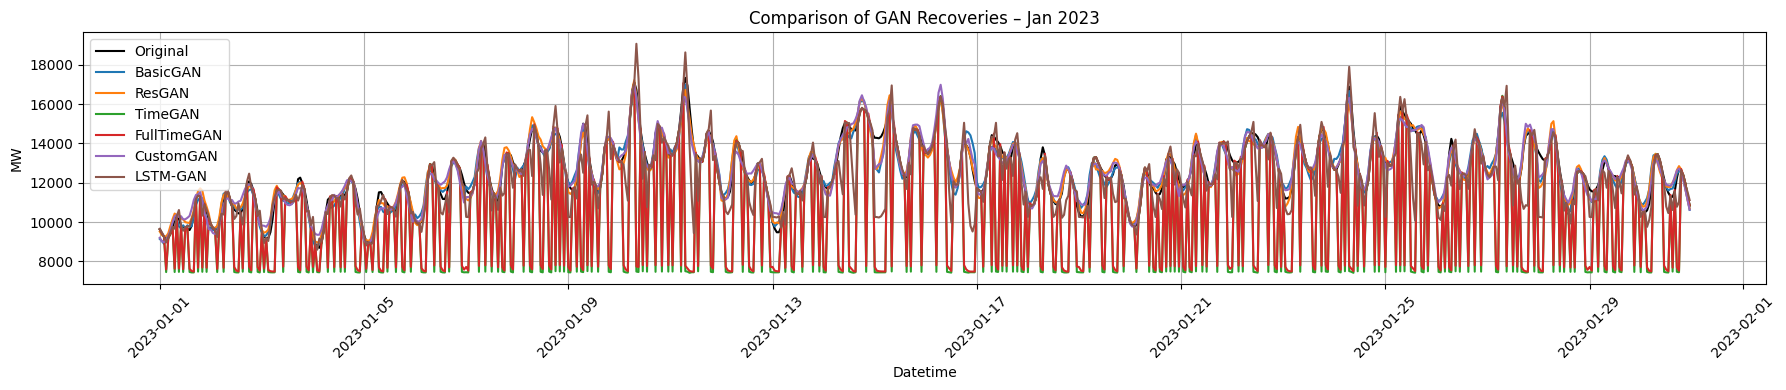

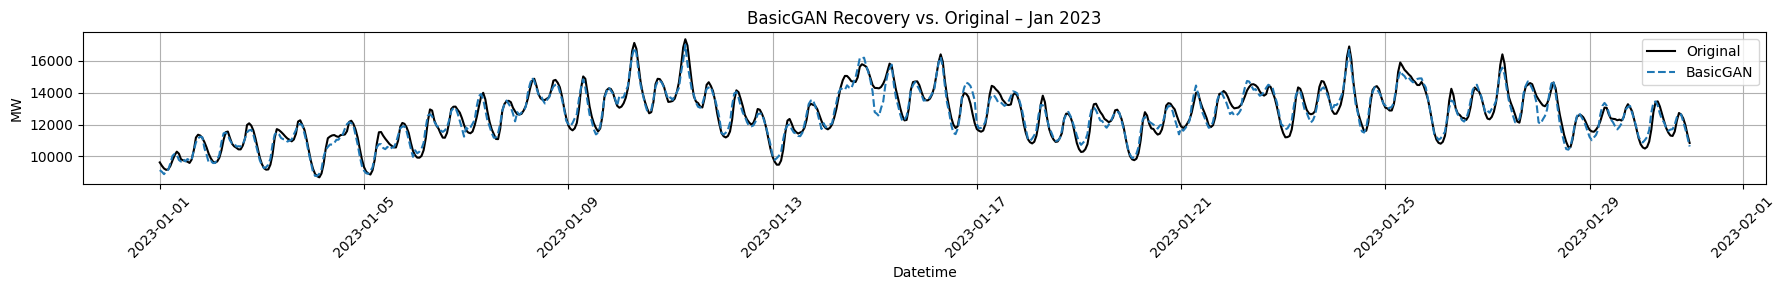

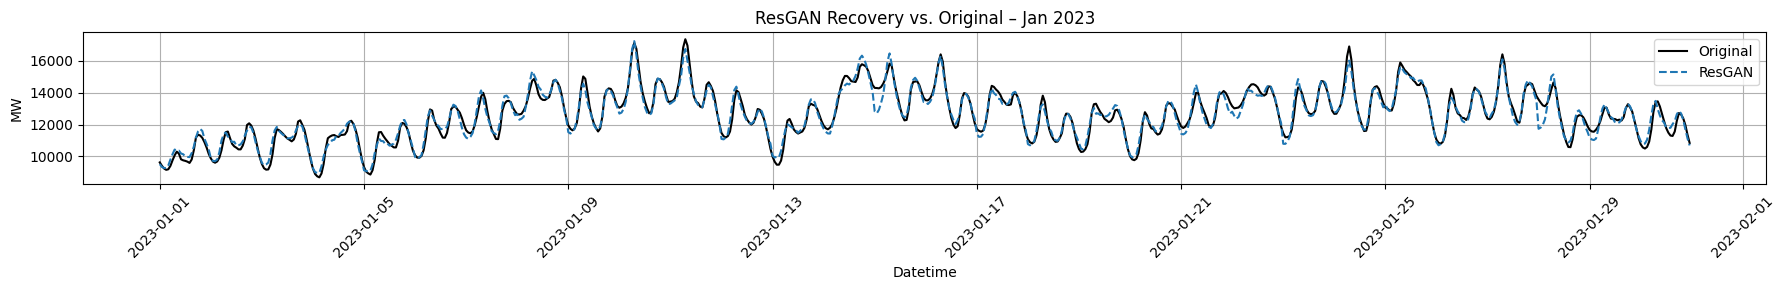

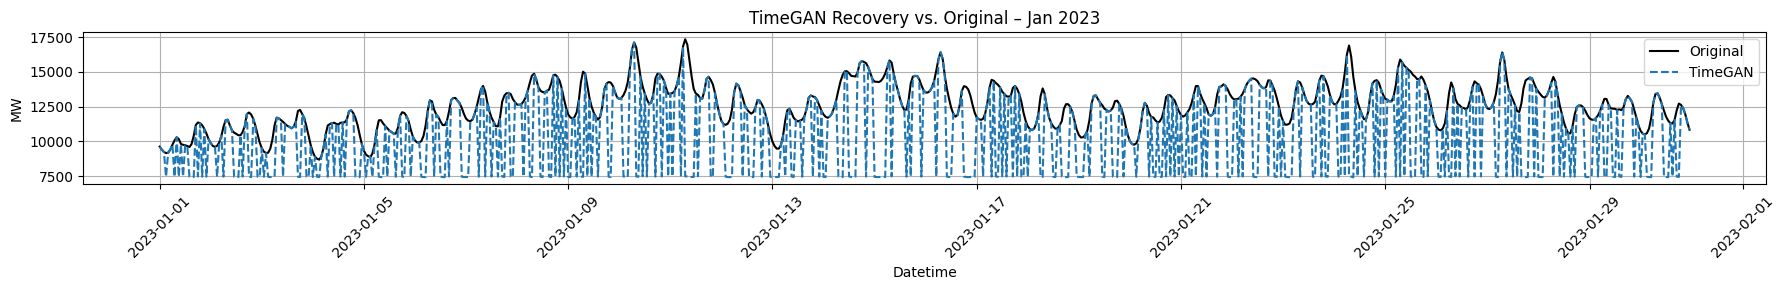

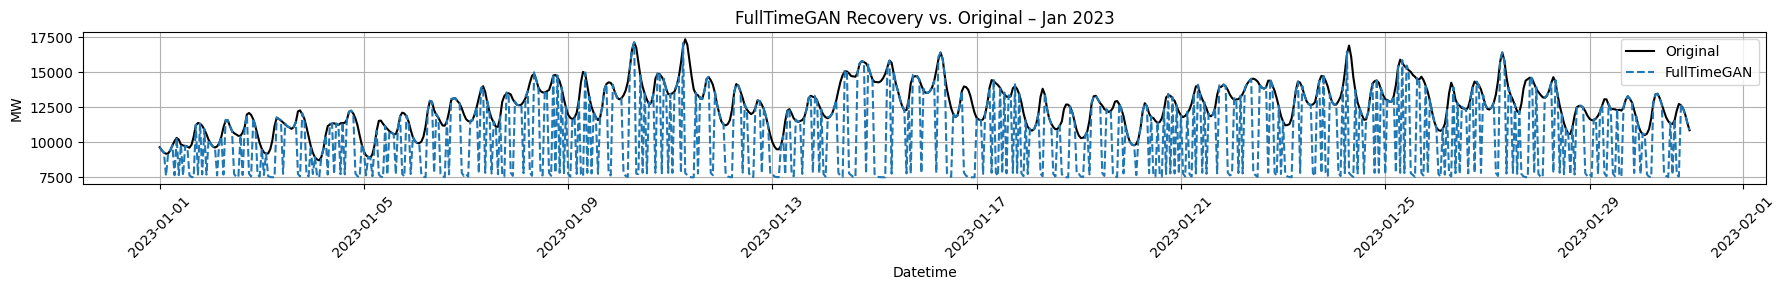

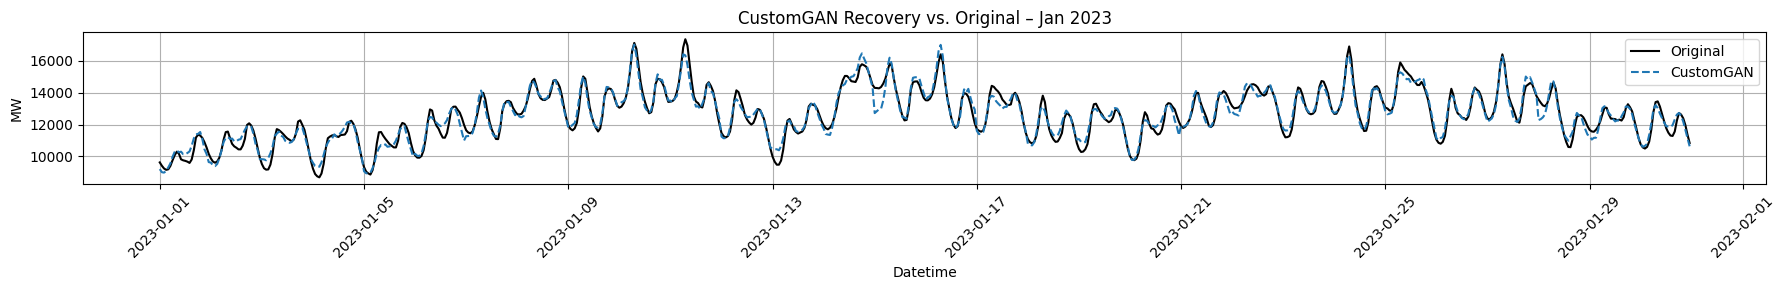

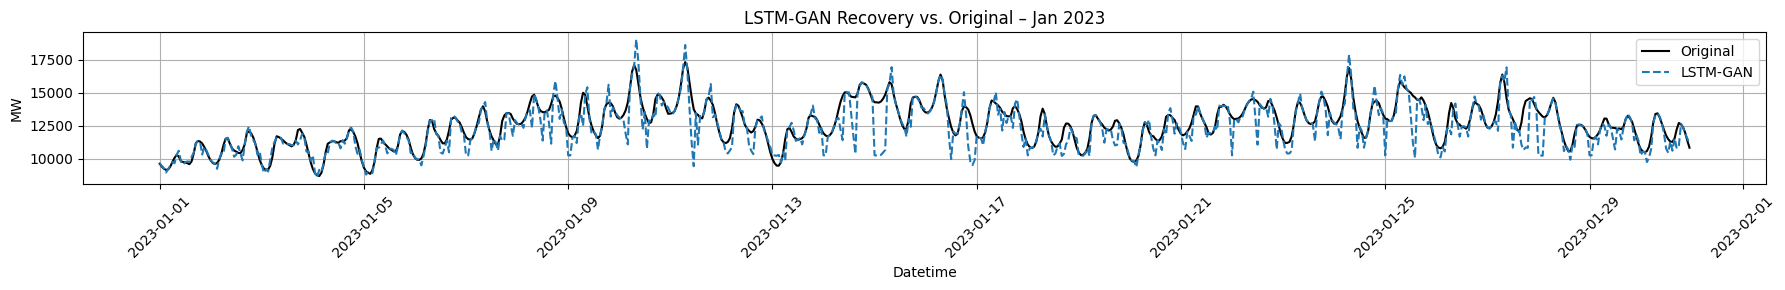

<ipython-input-27-fab43f5b7ed5>:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_index = pd.date_range(start=start_date, periods=periods, freq="H")


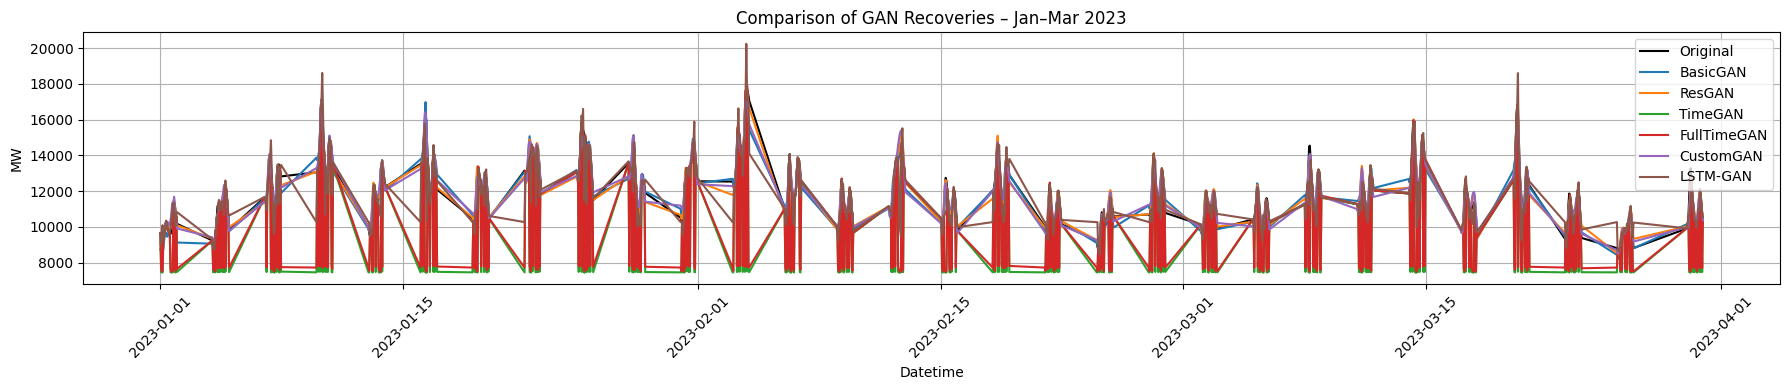

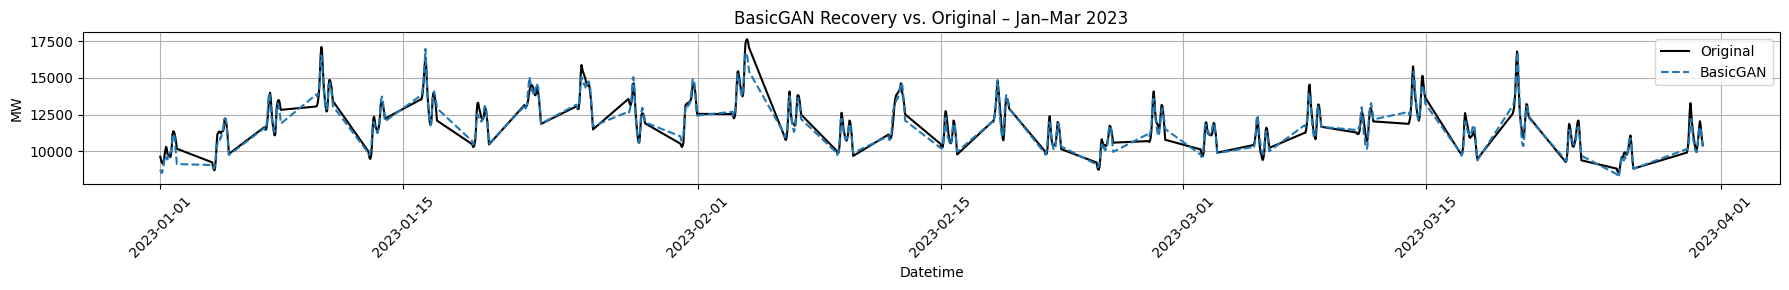

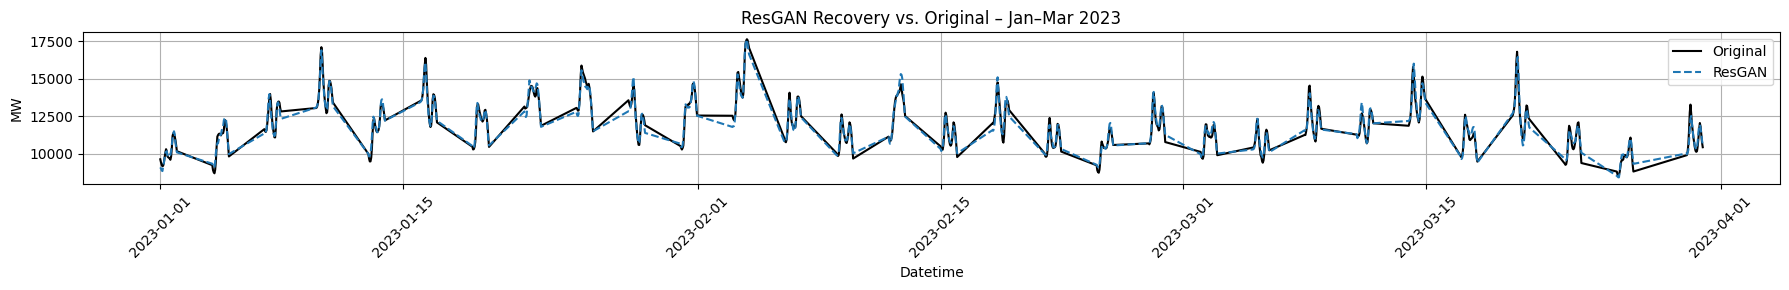

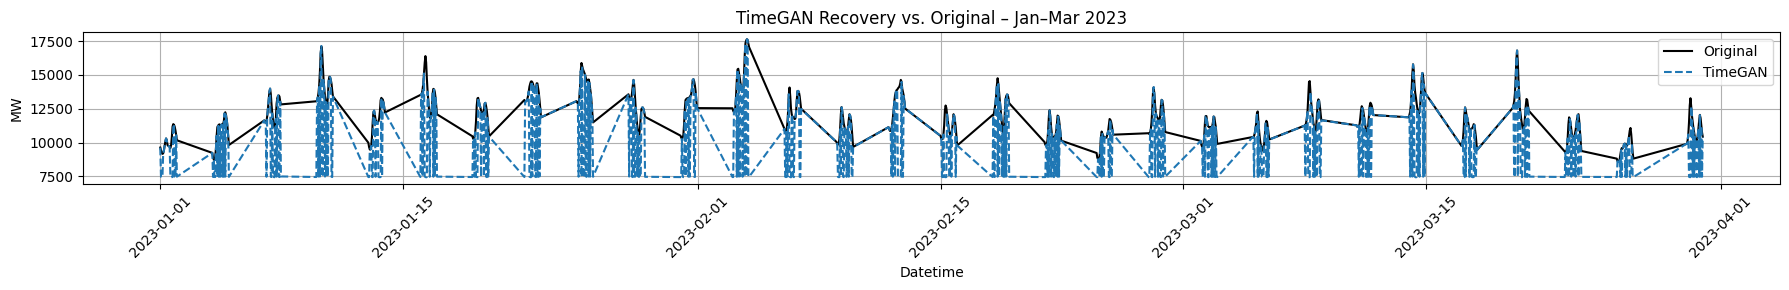

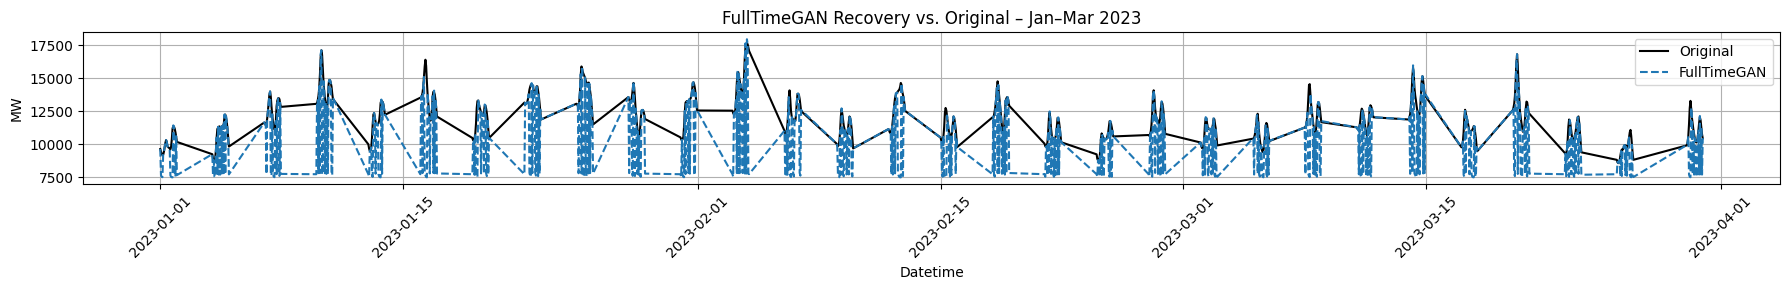

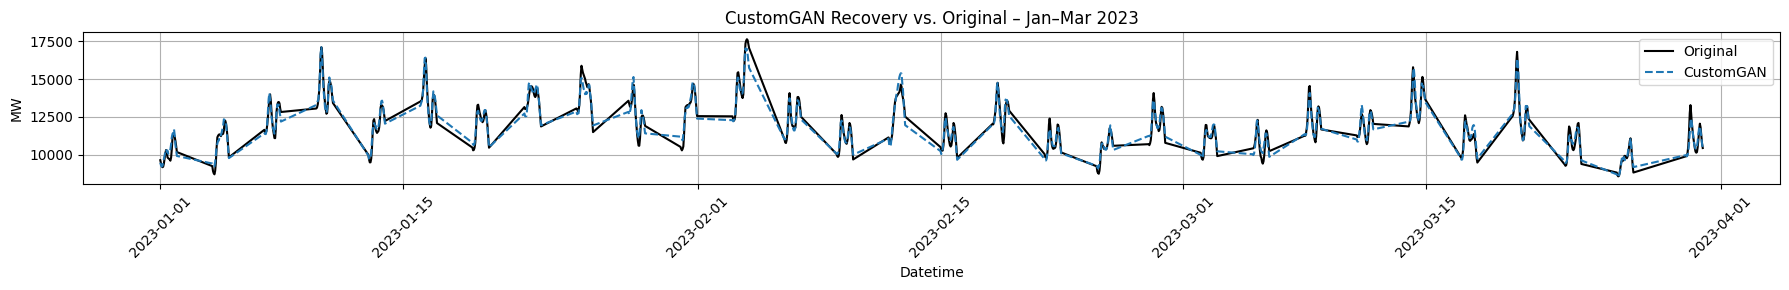

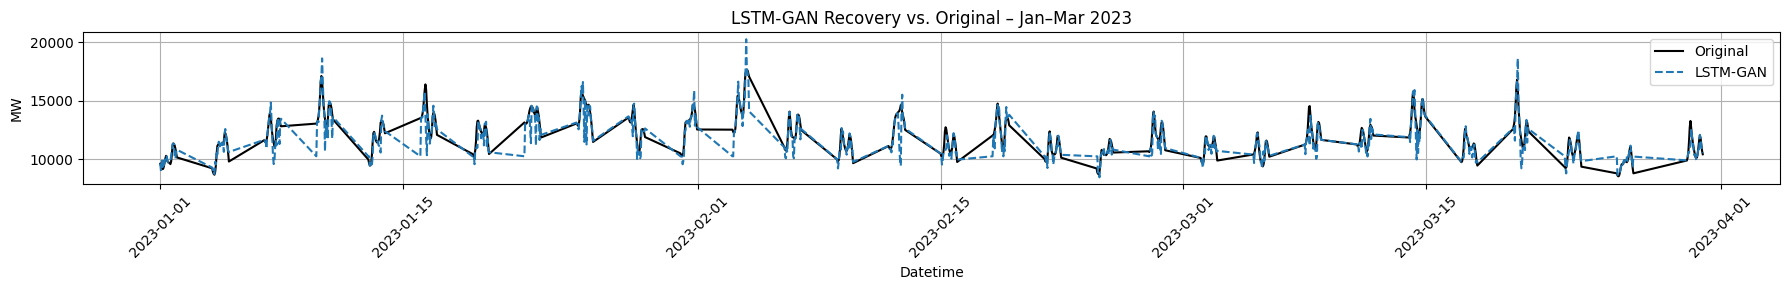

<ipython-input-27-fab43f5b7ed5>:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_index = pd.date_range(start=start_date, periods=periods, freq="H")


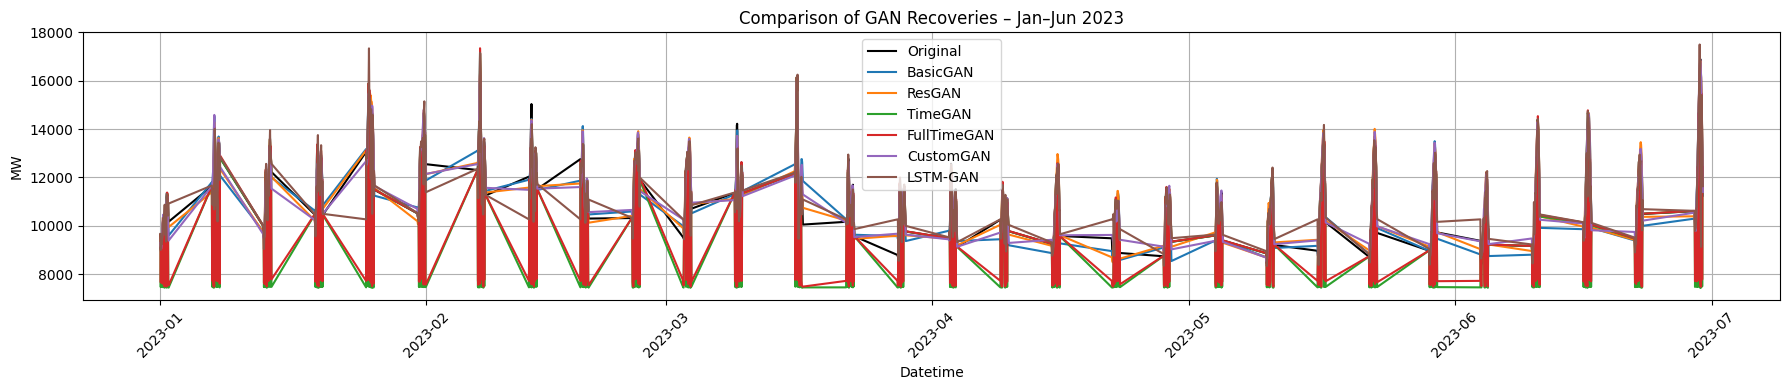

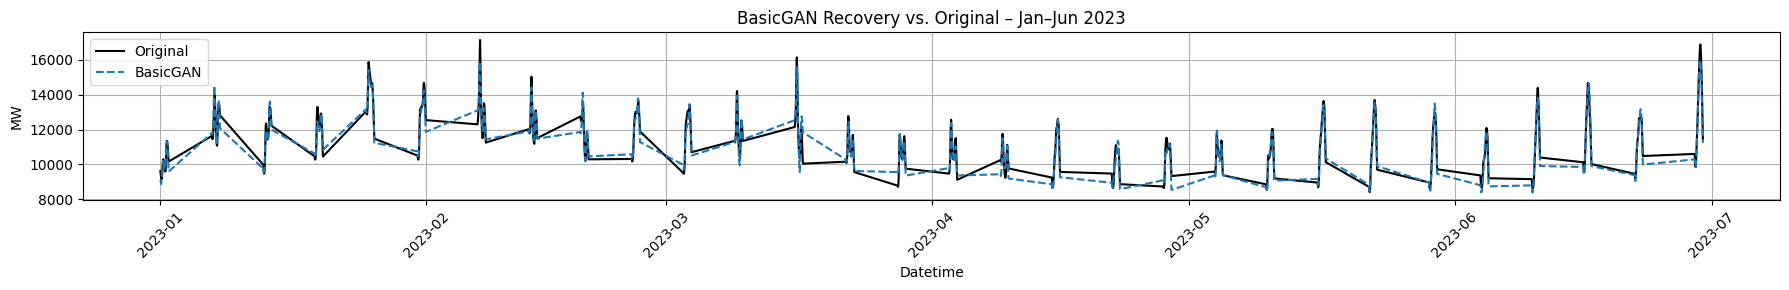

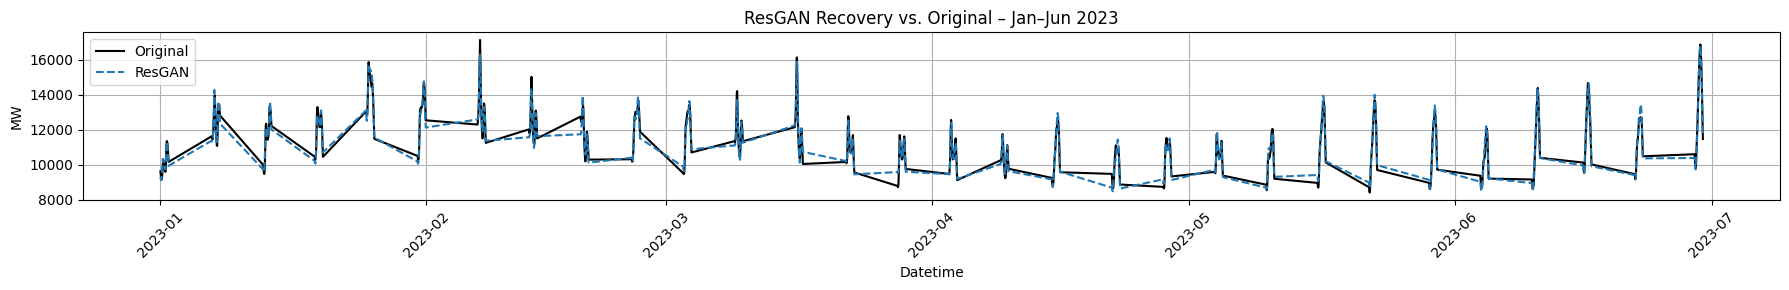

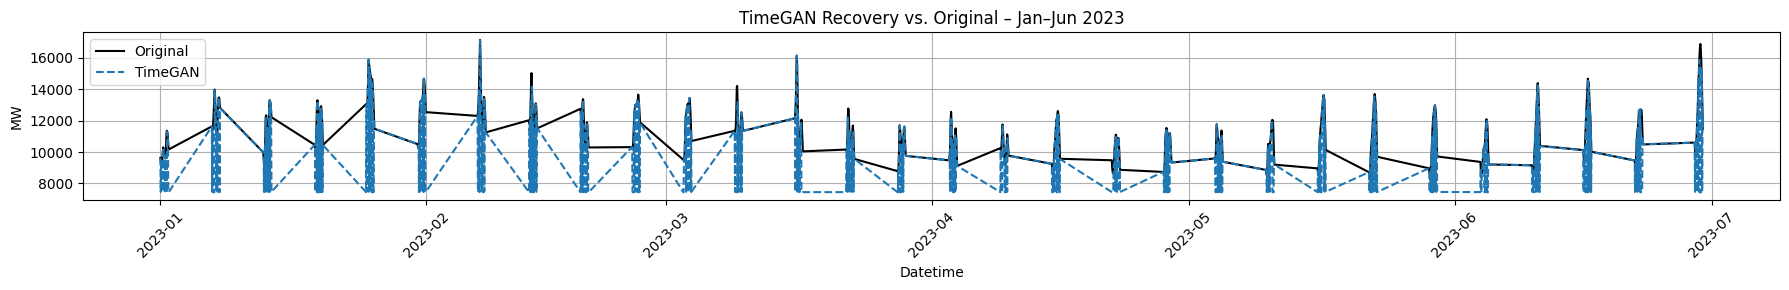

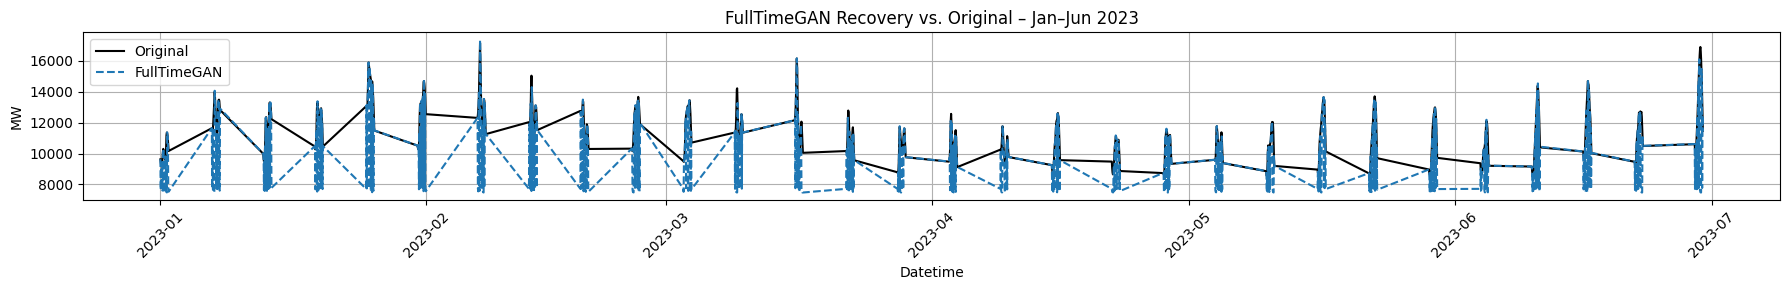

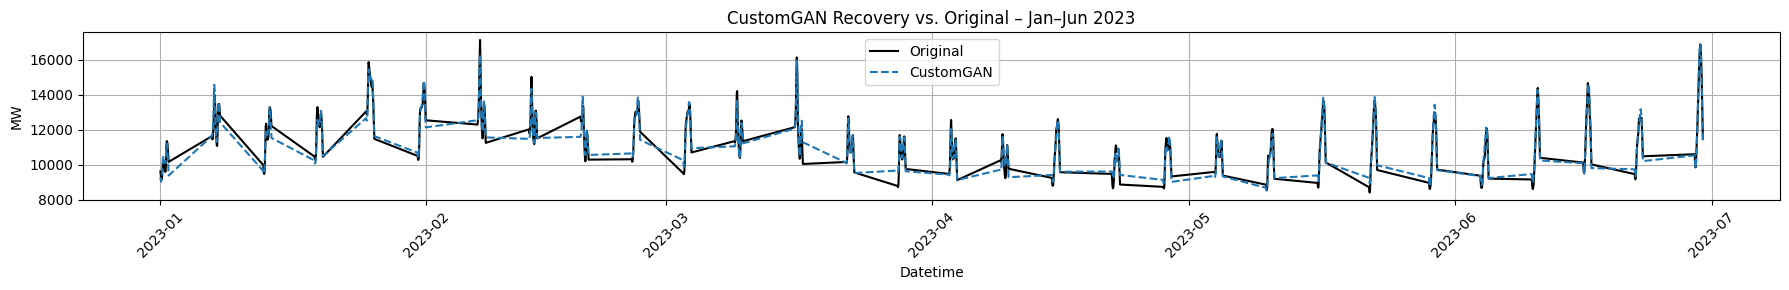

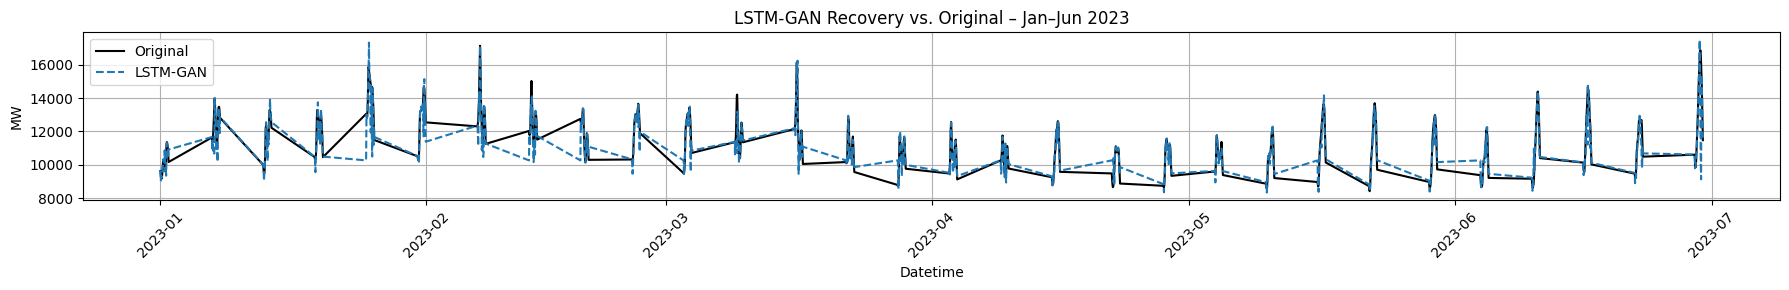

<ipython-input-27-fab43f5b7ed5>:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dt_index = pd.date_range(start=start_date, periods=periods, freq="H")


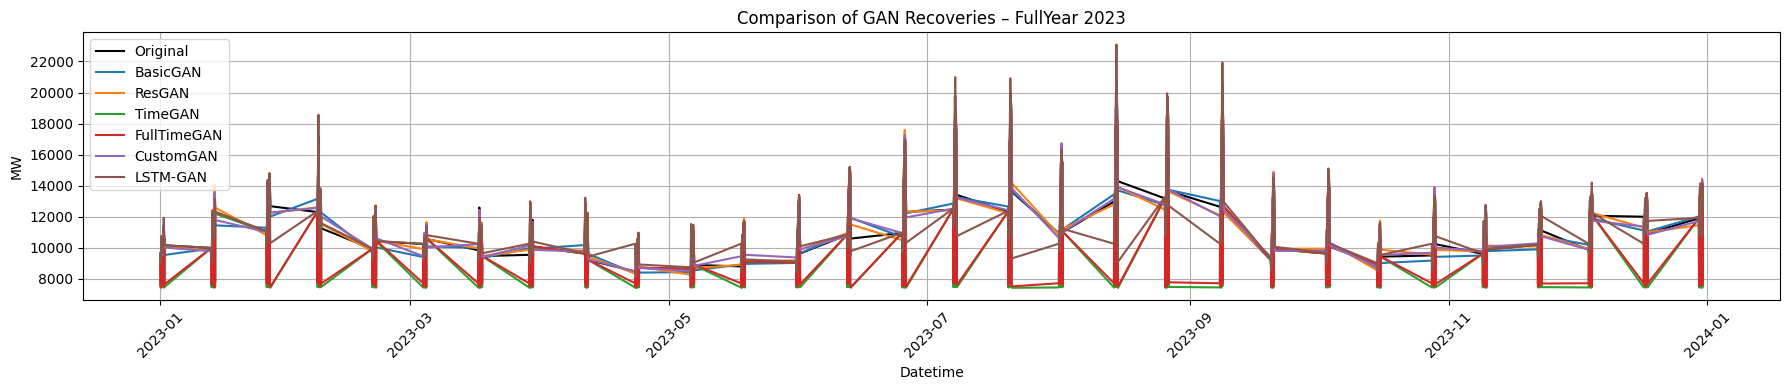

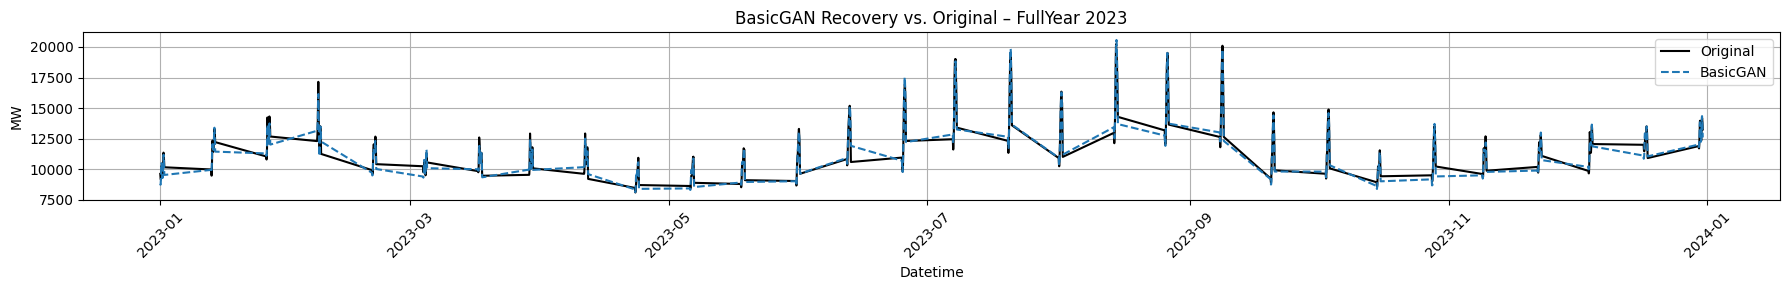

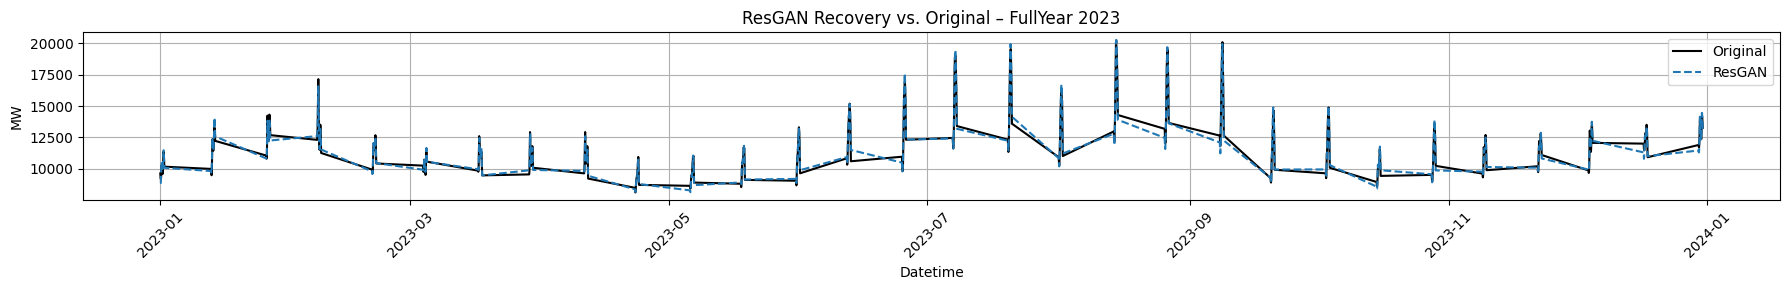

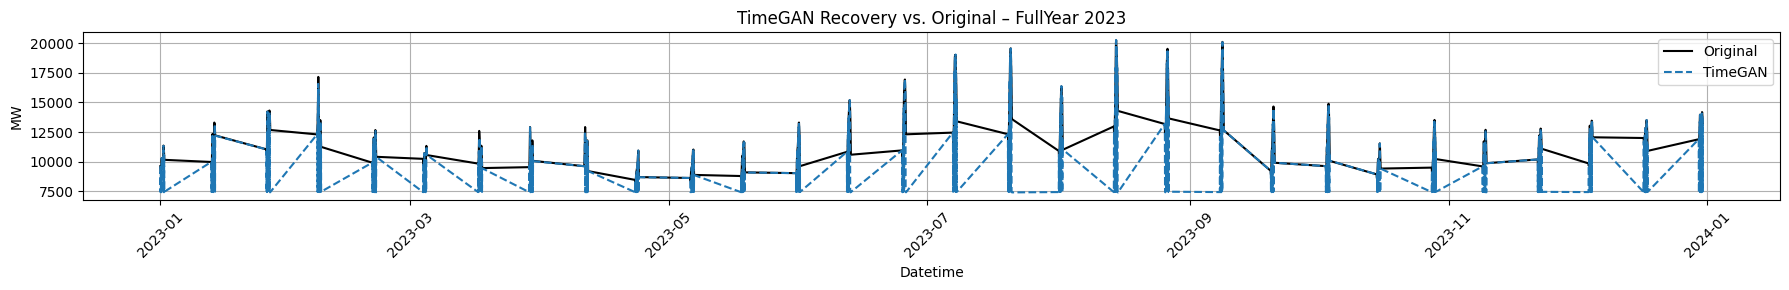

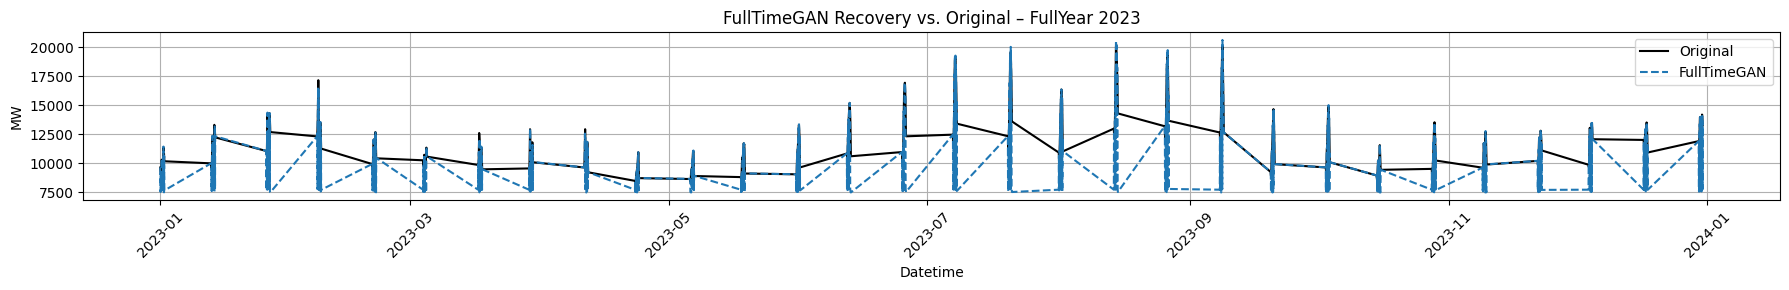

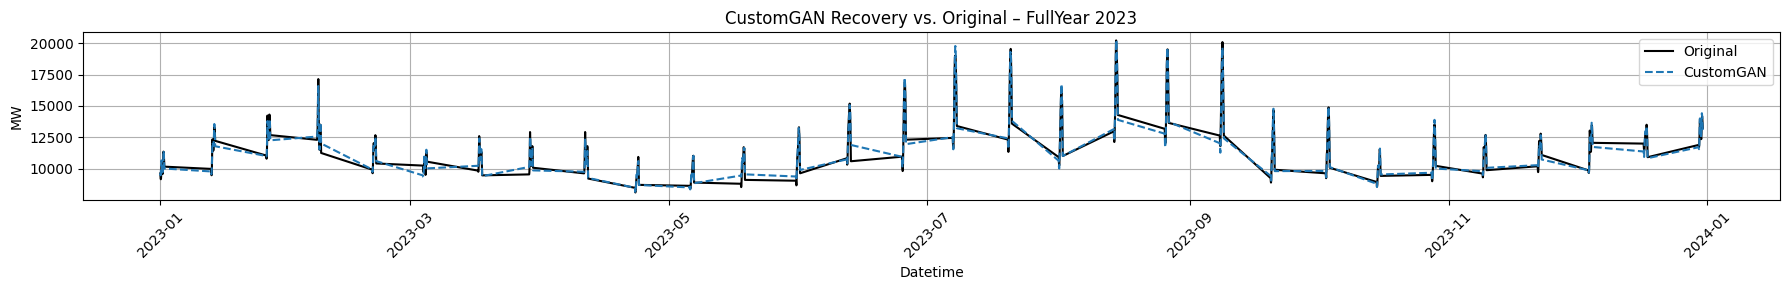

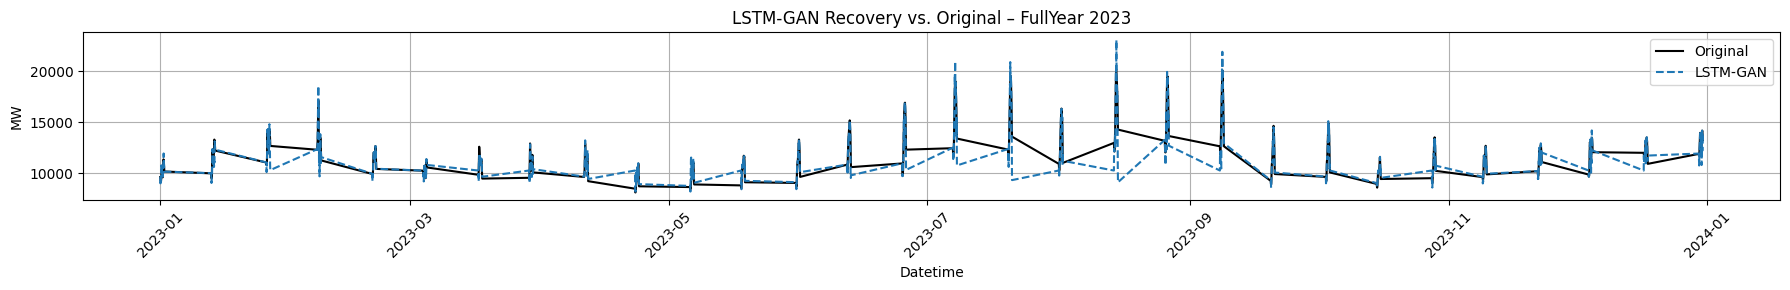

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load test data
labels = ["Jan", "Jan–Mar", "Jan–Jun", "FullYear"]
mw_test_cases = {label: np.load(f"/content/x_test_{label}.npy") for label in labels}
masked_seq_cases = {label: np.load(f"/content/Masked_{label}.npy") for label in labels}

# Load predictions
rec_dict = {
    "BasicGAN": {label: np.load(f"/content/BasicGAN_{label}.npy") for label in labels},
    "ResGAN": {label: np.load(f"/content/ResGAN_{label}.npy") for label in labels},
    "TimeGAN": {label: np.load(f"/content/TimeGAN_{label}.npy") for label in labels},
    "FullTimeGAN": {label: np.load(f"/content/FullTimeGAN_{label}.npy") for label in labels},
    "CustomGAN": {label: np.load(f"/content/CustomGAN_{label}.npy") for label in labels},
    "LSTM-GAN": {label: np.load(f"/content/LSTMGAN_{label}.npy") for label in labels}
}

# Load scaler
metered_df = pd.read_excel("/content/drive/MyDrive/DeepLearning/GAN/metered_data.xlsx")
metered_df = metered_df.dropna(axis=1, how='all').ffill().bfill()
MM_scaler = MinMaxScaler()
metered_train = metered_df[metered_df['year'].isin([2020, 2021, 2022, 2024])]
MM_scaler.fit(metered_train[['mw']])

# Plotting
def plot_all(label, step=1):
    original = mw_test_cases[label].squeeze(-1)
    masked = masked_seq_cases[label]
    recs = {name: rec_dict[name][label] for name in rec_dict}

    # Reconstruct datetimes
    start_date = "2023-01-01"
    periods = 24 * len(original)
    dt_index = pd.date_range(start=start_date, periods=periods, freq="H")

    # Sample 30 evenly spaced examples
    sample_idx = np.linspace(0, len(original) - 1, 30, dtype=int)
    merged = {"Datetime": [], "Original": []}
    for model in recs:
        merged[model] = []

    for i in sample_idx:
        dt = dt_index[i * 24:(i + 1) * 24]
        if len(dt) < 24:
            continue
        merged['Datetime'].extend(dt)
        merged['Original'].extend(original[i])
        for model in recs:
            merged[model].extend(recs[model][i])

    plot_df = pd.DataFrame(merged)

    # Inverse transform to MW
    for col in plot_df.columns:
        if col != "Datetime":
            plot_df[col] = MM_scaler.inverse_transform(plot_df[[col]])

    # Combined plot
    plt.figure(figsize=(18, 4))
    plt.plot(plot_df['Datetime'], plot_df['Original'], label="Original", color="black")
    for model in recs:
        plt.plot(plot_df['Datetime'], plot_df[model], label=model)
    plt.title(f"Comparison of GAN Recoveries – {label} 2023")
    plt.xlabel("Datetime")
    plt.ylabel("MW")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Individual model comparisons
    for model in recs:
        plt.figure(figsize=(18, 3))
        plt.plot(plot_df['Datetime'], plot_df['Original'], label="Original", color="black")
        plt.plot(plot_df['Datetime'], plot_df[model], label=model, linestyle='--')
        plt.title(f"{model} Recovery vs. Original – {label} 2023")
        plt.xlabel("Datetime")
        plt.ylabel("MW")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Run all
for label in labels:
    plot_all(label)

### RMSE

Dataset        Model           MSE      RMSE       MAE
0        Jan     BasicGAN  4.005257e-04  0.020013  0.016507
1        Jan       ResGAN  2.963206e-04  0.017214  0.013396
2        Jan      TimeGAN  7.715973e-07  0.000878  0.000700
3        Jan  FullTimeGAN  1.698022e-05  0.004121  0.002660
4        Jan    CustomGAN  3.222410e-04  0.017951  0.014170
5        Jan      LSTMGAN  2.431986e-05  0.004932  0.003712
6    Jan–Mar     BasicGAN  5.005172e-04  0.022372  0.017603
7    Jan–Mar       ResGAN  3.160160e-04  0.017777  0.013452
8    Jan–Mar      TimeGAN  7.634194e-07  0.000874  0.000701
9    Jan–Mar  FullTimeGAN  1.459246e-05  0.003820  0.002400
10   Jan–Mar    CustomGAN  3.930390e-04  0.019825  0.015673
11   Jan–Mar      LSTMGAN  2.515270e-05  0.005015  0.003756
12   Jan–Jun     BasicGAN  4.089673e-04  0.020223  0.015664
13   Jan–Jun       ResGAN  2.710566e-04  0.016464  0.012517
14   Jan–Jun      TimeGAN  6.806810e-07  0.000825  0.000648
15   Jan–Jun  FullTimeGAN  1.162149e-05  0.003409  0.002084
16   Jan–Jun    CustomGAN  3.490719e-04  0.018683  0.014433
17   Jan–Jun      LSTMGAN  2.469131e-05  0.004969  0.003697
18  FullYear     BasicGAN  3.975456e-04  0.019939  0.015466
19  FullYear       ResGAN  2.700934e-04  0.016435  0.012569
20  FullYear      TimeGAN  8.692424e-07  0.000932  0.000718
21  FullYear  FullTimeGAN  2.720344e-05  0.005216  0.002787
22  FullYear    CustomGAN  3.009598e-04  0.017348  0.013436
23  FullYear      LSTMGAN  2.941042e-05  0.005423  0.003857

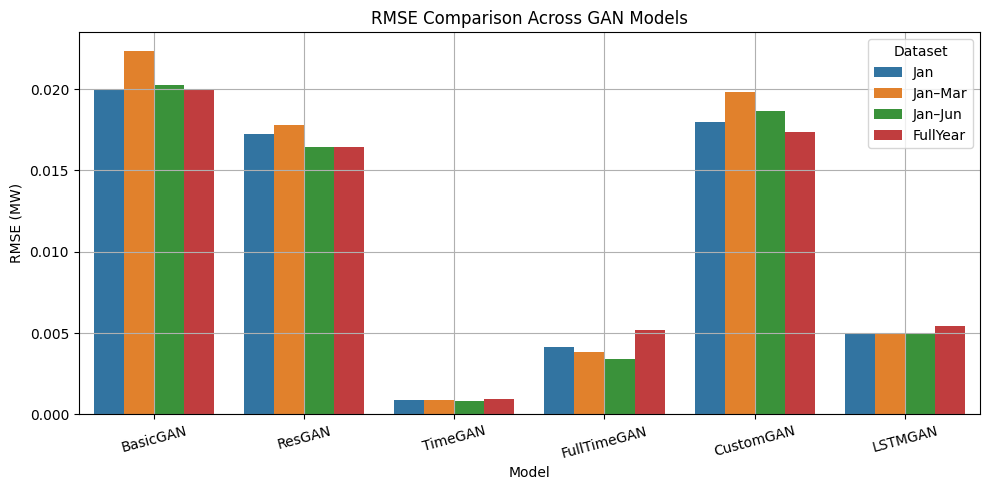

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

rmse_results = []

for label in ["Jan", "Jan–Mar", "Jan–Jun", "FullYear"]:
    mw_original = np.load(f"/content/x_test_{label}.npy").squeeze(-1)
    masked_seq = np.load(f"/content/Masked_{label}.npy")

    for model in ["BasicGAN", "ResGAN", "TimeGAN", "FullTimeGAN", "CustomGAN", "LSTMGAN"]:
        mw_recovered = np.load(f"/content/{model}_{label}.npy")

        # Only compare observed (unmasked) values
        mask = (masked_seq != 0).astype(int)
        mse = np.sum((mw_recovered - mw_original)**2 * mask) / np.sum(mask)
        rmse = np.sqrt(mse)
        mae = np.sum(np.abs(mw_recovered - mw_original) * mask) / np.sum(mask)

        rmse_results.append({
            "Dataset": label,
            "Model": model,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae
        })

# Show results
df_rmse_metrics = pd.DataFrame(rmse_results)
display(df_rmse_metrics)

# Optional: Plot RMSE comparison
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=df_rmse_metrics, x="Model", y="RMSE", hue="Dataset")
plt.title("RMSE Comparison Across GAN Models")
plt.ylabel("RMSE (MW)")
plt.xticks(rotation=15)
plt.grid(True)
plt.tight_layout()
plt.show()

# Testing with 64 different parameters setting (RMSE)

In [ ]:
import itertools

batch_sizes = [8, 16, 32, 64]
epochs_list = [100, 300, 500, 1000]
learning_rates = [0.0001, 0.001, 0.005, 0.01]

hyperparam_grid = list(itertools.product(batch_sizes, epochs_list, learning_rates))
print(f"Total combinations: {len(hyperparam_grid)}")  # Should be 64

Total combinations: 64


### TImeGAN Model Training with Different Parameters

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import os

x_train = np.load("/content/x_train_seq.npy")
x_train = np.expand_dims(x_train, -1)

def build_timegan_autoencoder(input_dim=1):
    model = models.Sequential([
        layers.Input((24, input_dim)),
        layers.GRU(64, return_sequences=True),
        layers.GRU(64, return_sequences=True),
        layers.TimeDistributed(layers.Dense(input_dim))
    ])
    return model

def train_timegan_variant(x_train, batch_size, epochs, lr, save_suffix):
    model = build_timegan_autoencoder()
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    model.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, verbose=0)
    model.save(f"/content/drive/MyDrive/DeepLearning/GAN/hparam_test/TimeGAN_autoencoder_{save_suffix}.h5")

# Loop for TimeGAN
for batch_size, epochs, lr in hyperparam_grid:
    suffix = f"bs{batch_size}_ep{epochs}_lr{lr}"
    print(f"Training TimeGAN AE with {suffix}")
    train_timegan_variant(x_train, batch_size, epochs, lr, suffix)

Training TimeGAN AE with bs8_ep100_lr0.0001


Training TimeGAN AE with bs8_ep100_lr0.001


Training TimeGAN AE with bs8_ep100_lr0.005


Training TimeGAN AE with bs8_ep100_lr0.01


Training TimeGAN AE with bs8_ep300_lr0.0001


Training TimeGAN AE with bs8_ep300_lr0.001


Training TimeGAN AE with bs8_ep300_lr0.005


Training TimeGAN AE with bs8_ep300_lr0.01


Training TimeGAN AE with bs8_ep500_lr0.0001


Training TimeGAN AE with bs8_ep500_lr0.001


Training TimeGAN AE with bs8_ep500_lr0.005


Training TimeGAN AE with bs8_ep500_lr0.01


Training TimeGAN AE with bs8_ep1000_lr0.0001


Training TimeGAN AE with bs8_ep1000_lr0.001


Training TimeGAN AE with bs8_ep1000_lr0.005


Training TimeGAN AE with bs8_ep1000_lr0.01


Training TimeGAN AE with bs16_ep100_lr0.0001


Training TimeGAN AE with bs16_ep100_lr0.001


Training TimeGAN AE with bs16_ep100_lr0.005


Training TimeGAN AE with bs16_ep100_lr0.01


Training TimeGAN AE with bs16_ep300_lr0.0001


Training TimeGAN AE with bs16_ep300_lr0.001


Training TimeGAN AE with bs16_ep300_lr0.005


Training TimeGAN AE with bs16_ep300_lr0.01


Training TimeGAN AE with bs16_ep500_lr0.0001


Training TimeGAN AE with bs16_ep500_lr0.001


Training TimeGAN AE with bs16_ep500_lr0.005


Training TimeGAN AE with bs16_ep500_lr0.01


Training TimeGAN AE with bs16_ep1000_lr0.0001


Training TimeGAN AE with bs16_ep1000_lr0.001


Training TimeGAN AE with bs16_ep1000_lr0.005


Training TimeGAN AE with bs16_ep1000_lr0.01


Training TimeGAN AE with bs32_ep100_lr0.0001


Training TimeGAN AE with bs32_ep100_lr0.001


Training TimeGAN AE with bs32_ep100_lr0.005


Training TimeGAN AE with bs32_ep100_lr0.01


Training TimeGAN AE with bs32_ep300_lr0.0001


Training TimeGAN AE with bs32_ep300_lr0.001


Training TimeGAN AE with bs32_ep300_lr0.005


Training TimeGAN AE with bs32_ep300_lr0.01


Training TimeGAN AE with bs32_ep500_lr0.0001


Training TimeGAN AE with bs32_ep500_lr0.001


Training TimeGAN AE with bs32_ep500_lr0.005


Training TimeGAN AE with bs32_ep500_lr0.01


Training TimeGAN AE with bs32_ep1000_lr0.0001


Training TimeGAN AE with bs32_ep1000_lr0.001


Training TimeGAN AE with bs32_ep1000_lr0.005


Training TimeGAN AE with bs32_ep1000_lr0.01


Training TimeGAN AE with bs64_ep100_lr0.0001


Training TimeGAN AE with bs64_ep100_lr0.001


Training TimeGAN AE with bs64_ep100_lr0.005


Training TimeGAN AE with bs64_ep100_lr0.01


Training TimeGAN AE with bs64_ep300_lr0.0001


Training TimeGAN AE with bs64_ep300_lr0.001


Training TimeGAN AE with bs64_ep300_lr0.005


Training TimeGAN AE with bs64_ep300_lr0.01


Training TimeGAN AE with bs64_ep500_lr0.0001


Training TimeGAN AE with bs64_ep500_lr0.001


Training TimeGAN AE with bs64_ep500_lr0.005


Training TimeGAN AE with bs64_ep500_lr0.01


Training TimeGAN AE with bs64_ep1000_lr0.0001


Training TimeGAN AE with bs64_ep1000_lr0.001


Training TimeGAN AE with bs64_ep1000_lr0.005


Training TimeGAN AE with bs64_ep1000_lr0.01


### GAIn GAN Model Training with Different Parameters

In [ ]:
import torch
import torch.nn as nn
from tqdm import trange
import numpy as np

x_train = np.load("/content/x_train_seq.npy")

class GAINGenerator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len * 2, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, seq_len)
        )
    def forward(self, masked, mask):
        return self.net(torch.cat([masked, mask], dim=1))

class GAINDiscriminator(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(seq_len, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def train_GAIN_gan_variant(x_train, batch_size, epochs, lr, save_suffix):
    seq_len = x_train.shape[1]
    G = GAINGenerator(seq_len)
    D = GAINDiscriminator(seq_len)

    g_opt = torch.optim.Adam(G.parameters(), lr=lr)
    d_opt = torch.optim.Adam(D.parameters(), lr=lr)
    bce = nn.BCELoss()
    mse = nn.MSELoss()

    def mask_fn(data):
        mask = (np.random.rand(*data.shape) > 0.4).astype(float)
        return data * mask, mask

    for epoch in range(epochs):
        idx = np.random.permutation(len(x_train))
        pbar = trange(0, len(x_train), batch_size, desc=f"[CustomGAN-{save_suffix}] Epoch {epoch+1}/{epochs}", leave=False)
        for i in pbar:
            batch = x_train[idx[i:i+batch_size]].squeeze(-1)
            masked, mask = mask_fn(batch)
            batch = torch.FloatTensor(batch)
            masked = torch.FloatTensor(masked)
            mask = torch.FloatTensor(mask)

            real_label = torch.ones((len(batch), 1))
            fake_label = torch.zeros((len(batch), 1))

            fake = G(masked, mask).detach()
            d_real = D(batch)
            d_fake = D(fake)
            d_loss = bce(d_real, real_label) + bce(d_fake, fake_label)
            d_opt.zero_grad(); d_loss.backward(); d_opt.step()

            fake = G(masked, mask)
            d_fake = D(fake)
            g_loss = bce(d_fake, real_label) + mse(fake * mask, batch * mask)
            g_opt.zero_grad(); g_loss.backward(); g_opt.step()

    torch.save(G.state_dict(), f"/content/drive/MyDrive/DeepLearning/GAN/hparam_test/CustomGAN_generator_{save_suffix}.pth")

# Loop for GAINGAN
for batch_size, epochs, lr in hyperparam_grid:
    suffix = f"bs{batch_size}_ep{epochs}_lr{lr}"
    print(f"Training GAINGAN with {suffix}")
    train_GAIN_gan_variant(x_train, batch_size, epochs, lr, suffix)

Training CustomGAN with bs8_ep100_lr0.0001


Training CustomGAN with bs8_ep100_lr0.001


Training CustomGAN with bs8_ep100_lr0.005


Training CustomGAN with bs8_ep100_lr0.01


Training CustomGAN with bs8_ep300_lr0.0001


Training CustomGAN with bs8_ep300_lr0.001


Training CustomGAN with bs8_ep300_lr0.005


Training CustomGAN with bs8_ep300_lr0.01


Training CustomGAN with bs8_ep500_lr0.0001


Training CustomGAN with bs8_ep500_lr0.001


Training CustomGAN with bs8_ep500_lr0.005


Training CustomGAN with bs8_ep500_lr0.01


Training CustomGAN with bs8_ep1000_lr0.0001


Training CustomGAN with bs8_ep1000_lr0.001


Training CustomGAN with bs8_ep1000_lr0.005


Training CustomGAN with bs8_ep1000_lr0.01


Training CustomGAN with bs16_ep100_lr0.0001


Training CustomGAN with bs16_ep100_lr0.001


Training CustomGAN with bs16_ep100_lr0.005


Training CustomGAN with bs16_ep100_lr0.01


Training CustomGAN with bs16_ep300_lr0.0001


Training CustomGAN with bs16_ep300_lr0.001


Training CustomGAN with bs16_ep300_lr0.005


Training CustomGAN with bs16_ep300_lr0.01


Training CustomGAN with bs16_ep500_lr0.0001


Training CustomGAN with bs16_ep500_lr0.001


Training CustomGAN with bs16_ep500_lr0.005


Training CustomGAN with bs16_ep500_lr0.01


Training CustomGAN with bs16_ep1000_lr0.0001


Training CustomGAN with bs16_ep1000_lr0.001


Training CustomGAN with bs16_ep1000_lr0.005


Training CustomGAN with bs16_ep1000_lr0.01


Training CustomGAN with bs32_ep100_lr0.0001


Training CustomGAN with bs32_ep100_lr0.001


Training CustomGAN with bs32_ep100_lr0.005


Training CustomGAN with bs32_ep100_lr0.01


Training CustomGAN with bs32_ep300_lr0.0001


Training CustomGAN with bs32_ep300_lr0.001


Training CustomGAN with bs32_ep300_lr0.005


Training CustomGAN with bs32_ep300_lr0.01


Training CustomGAN with bs32_ep500_lr0.0001


Training CustomGAN with bs32_ep500_lr0.001


Training CustomGAN with bs32_ep500_lr0.005


Training CustomGAN with bs32_ep500_lr0.01


Training CustomGAN with bs32_ep1000_lr0.0001


Training CustomGAN with bs32_ep1000_lr0.001


Training CustomGAN with bs32_ep1000_lr0.005


Training CustomGAN with bs32_ep1000_lr0.01


Training CustomGAN with bs64_ep100_lr0.0001


Training CustomGAN with bs64_ep100_lr0.001


Training CustomGAN with bs64_ep100_lr0.005


Training CustomGAN with bs64_ep100_lr0.01


Training CustomGAN with bs64_ep300_lr0.0001


Training CustomGAN with bs64_ep300_lr0.001


Training CustomGAN with bs64_ep300_lr0.005


Training CustomGAN with bs64_ep300_lr0.01


Training CustomGAN with bs64_ep500_lr0.0001


Training CustomGAN with bs64_ep500_lr0.001


Training CustomGAN with bs64_ep500_lr0.005


Training CustomGAN with bs64_ep500_lr0.01


Training CustomGAN with bs64_ep1000_lr0.0001


Training CustomGAN with bs64_ep1000_lr0.001


Training CustomGAN with bs64_ep1000_lr0.005


Training CustomGAN with bs64_ep1000_lr0.01


# Plot the results (64 tests)

### GAIN GAN (64 tests)

100%|██████████| 64/64 [00:00<00:00, 88.30it/s]


   BatchSize  Epochs      LR      RMSE
0         16    1000  0.0001  0.020006
1         16    1000  0.0010  0.028406
2         16    1000  0.0050  1.444494
3         16    1000  0.0100  2.925504
4         16     100  0.0001  0.057706


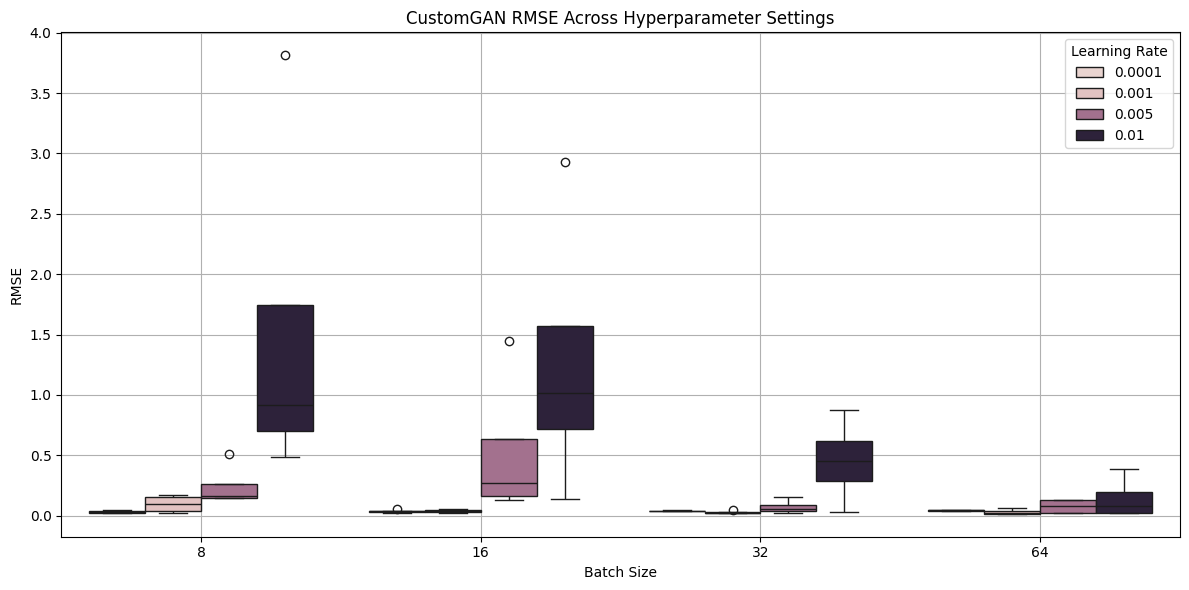

In [ ]:
# Re-import libraries after kernel reset
import os
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# Load masked test data
x_test = np.load("/content/x_test_FullYear.npy").squeeze(-1)
masked = x_test.copy()
masks = np.ones_like(x_test)
for i in range(len(masked)):
    idx = np.random.choice(24, 10, replace=False)
    masked[i, idx] = 0
    masks[i, idx] = 0

# Load scaler for inverse transform
df = pd.read_excel("/content/drive/MyDrive/DeepLearning/GAN/metered_data.xlsx")
df = df.dropna(axis=1, how='all').ffill().bfill()
df_train = df[df['year'].isin([2020, 2021, 2022, 2024])]
scaler = MinMaxScaler()
scaler.fit(df_train[['mw']])

# Define Custom Generator
class GAINGenerator(torch.nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(seq_len * 2, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(256, 256),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Linear(256, seq_len)
        )
    def forward(self, masked, mask):
        return self.net(torch.cat([masked, mask], dim=1))

# RMSE Comparison for CustomGAN variants
base_path = "/content/drive/MyDrive/DeepLearning/GAN/hparam_test"
custom_models = sorted([f for f in os.listdir(base_path) if f.startswith("CustomGAN_generator") and f.endswith(".pth")])

rmse_list = []
for file in tqdm(custom_models):
    G = GAINGenerator(24)
    G.load_state_dict(torch.load(os.path.join(base_path, file)))
    G.eval()
    with torch.no_grad():
        pred = G(torch.FloatTensor(masked), torch.FloatTensor(masks)).numpy()
    np.save(os.path.join(base_path, file.replace(".pth", ".npy")), pred)

    # Calculate RMSE
    mask = (masks != 0).astype(int)
    mse = np.sum((pred - x_test)**2 * mask) / np.sum(mask)
    rmse = np.sqrt(mse)

    # Extract hyperparams
    parts = file.replace(".pth", "").split("_")
    bs = parts[2].replace("bs", "")
    ep = parts[3].replace("ep", "")
    lr = parts[4].replace("lr", "")

    rmse_list.append({"BatchSize": int(bs), "Epochs": int(ep), "LR": float(lr), "RMSE": rmse})

# Convert to DataFrame and plot
df_rmse_customgan = pd.DataFrame(rmse_list)
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Show DataFrame
print(df_rmse_customgan.head())

# Plot RMSE grouped by (batch size, learning rate)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_rmse_customgan, x="BatchSize", y="RMSE", hue="LR")
plt.title("CustomGAN RMSE Across Hyperparameter Settings")
plt.ylabel("RMSE")
plt.xlabel("Batch Size")
plt.legend(title="Learning Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

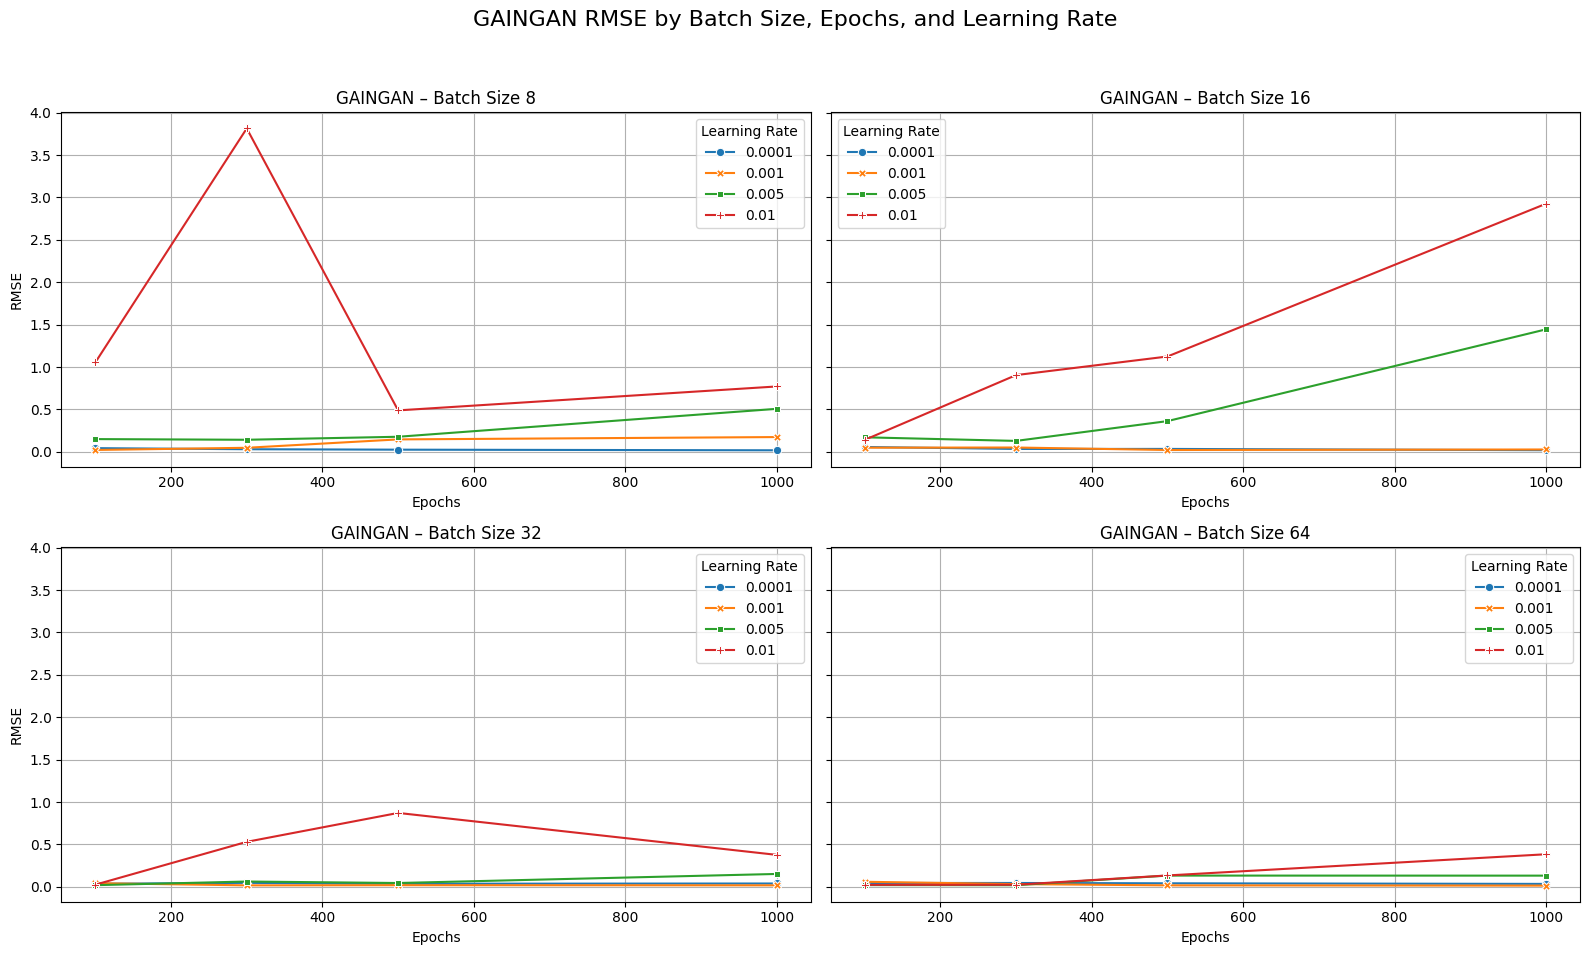

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure your dataframe is sorted (optional)
df_rmse_customgan_sorted = df_rmse_customgan.sort_values(by=["BatchSize", "Epochs", "LR"])

# Set of batch sizes you tested
batch_sizes = sorted(df_rmse_customgan_sorted["BatchSize"].unique())

# Create subplots: 2 rows × 2 columns
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
axes = axes.flatten()

# Create one subplot per batch size
for i, batch in enumerate(batch_sizes):
    subset = df_rmse_customgan_sorted[df_rmse_customgan_sorted["BatchSize"] == batch]
    sns.lineplot(
        data=subset,
        x="Epochs",
        y="RMSE",
        hue="LR",
        style="LR",
        markers=True,
        dashes=False,
        ax=axes[i],
        palette="tab10"
    )
    axes[i].set_title(f"GAINGAN – Batch Size {batch}")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("RMSE")
    axes[i].grid(True)
    axes[i].legend(title="Learning Rate")

plt.suptitle("GAINGAN RMSE by Batch Size, Epochs, and Learning Rate", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import os

base_path = "/content/drive/MyDrive/DeepLearning/GAN/hparam_test"

# Check CustomGAN predictions
custom_files = [f for f in os.listdir(base_path) if f.startswith("CustomGAN_generator") and f.endswith(".npy")]
print(f"CustomGAN predictions: {len(custom_files)}")
print(custom_files[:5])  # show few samples

# Check TimeGAN models
timegan_files = [f for f in os.listdir(base_path) if f.startswith("TimeGAN_autoencoder") and f.endswith(".h5")]
print(f"TimeGAN autoencoders: {len(timegan_files)}")
print(timegan_files[:5])  # show few samples


CustomGAN predictions: 0
[]
TimeGAN autoencoders: 64
['TimeGAN_autoencoder_bs8_ep100_lr0.0001.h5', 'TimeGAN_autoencoder_bs8_ep100_lr0.001.h5', 'TimeGAN_autoencoder_bs8_ep100_lr0.005.h5', 'TimeGAN_autoencoder_bs8_ep100_lr0.01.h5', 'TimeGAN_autoencoder_bs8_ep300_lr0.0001.h5']


### TimeGAN (64 tests)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


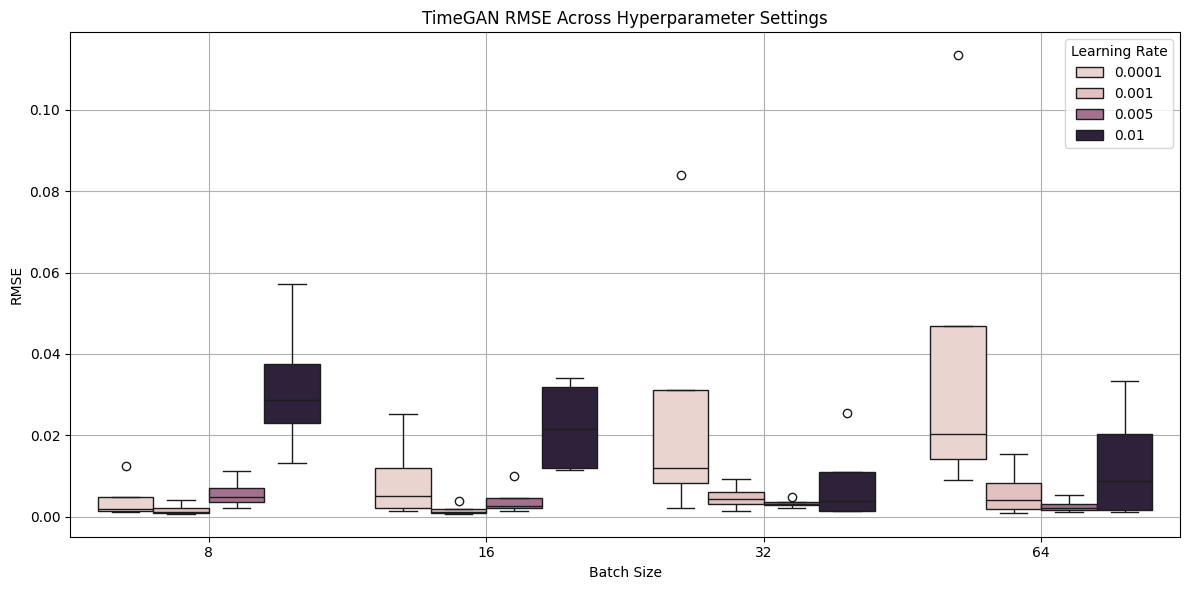

In [ ]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Set base path
base_path = "/content/drive/MyDrive/DeepLearning/GAN/hparam_test"
timegan_models = sorted([f for f in os.listdir(base_path) if f.startswith("TimeGAN_autoencoder") and f.endswith(".h5")])

# Load masked test set
x_test = np.load("/content/x_test_FullYear.npy").squeeze(-1)
masked = x_test.copy()
masks = np.ones_like(x_test)
for i in range(len(masked)):
    idx = np.random.choice(24, 10, replace=False)
    masked[i, idx] = 0
    masks[i, idx] = 0

# Load scaler
df = pd.read_excel("/content/drive/MyDrive/DeepLearning/GAN/metered_data.xlsx")
df = df.dropna(axis=1, how='all').ffill().bfill()
df_train = df[df['year'].isin([2020, 2021, 2022, 2024])]
scaler = MinMaxScaler()
scaler.fit(df_train[['mw']])

# Predict and collect RMSEs
results = []
for file in timegan_models:
    model_path = os.path.join(base_path, file)
    model = load_model(model_path, compile=False)
    rec = model.predict(np.expand_dims(masked, -1)).squeeze(-1)

    mask = (masks != 0).astype(int)
    mse = np.sum((rec - x_test)**2 * mask) / np.sum(mask)
    rmse = np.sqrt(mse)

    # Extract hyperparameters from filename
    name = file.replace("TimeGAN_autoencoder_", "").replace(".h5", "")
    parts = name.split("_")
    batch_size = int(parts[0][2:])
    epochs = int(parts[1][2:])
    lr = float(parts[2][2:])

    results.append({
        "BatchSize": batch_size,
        "Epochs": epochs,
        "LR": lr,
        "RMSE": rmse
    })

df_rmse_timegan = pd.DataFrame(results)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_rmse_timegan, x="BatchSize", y="RMSE", hue="LR")
plt.title("TimeGAN RMSE Across Hyperparameter Settings")
plt.ylabel("RMSE")
plt.xlabel("Batch Size")
plt.legend(title="Learning Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

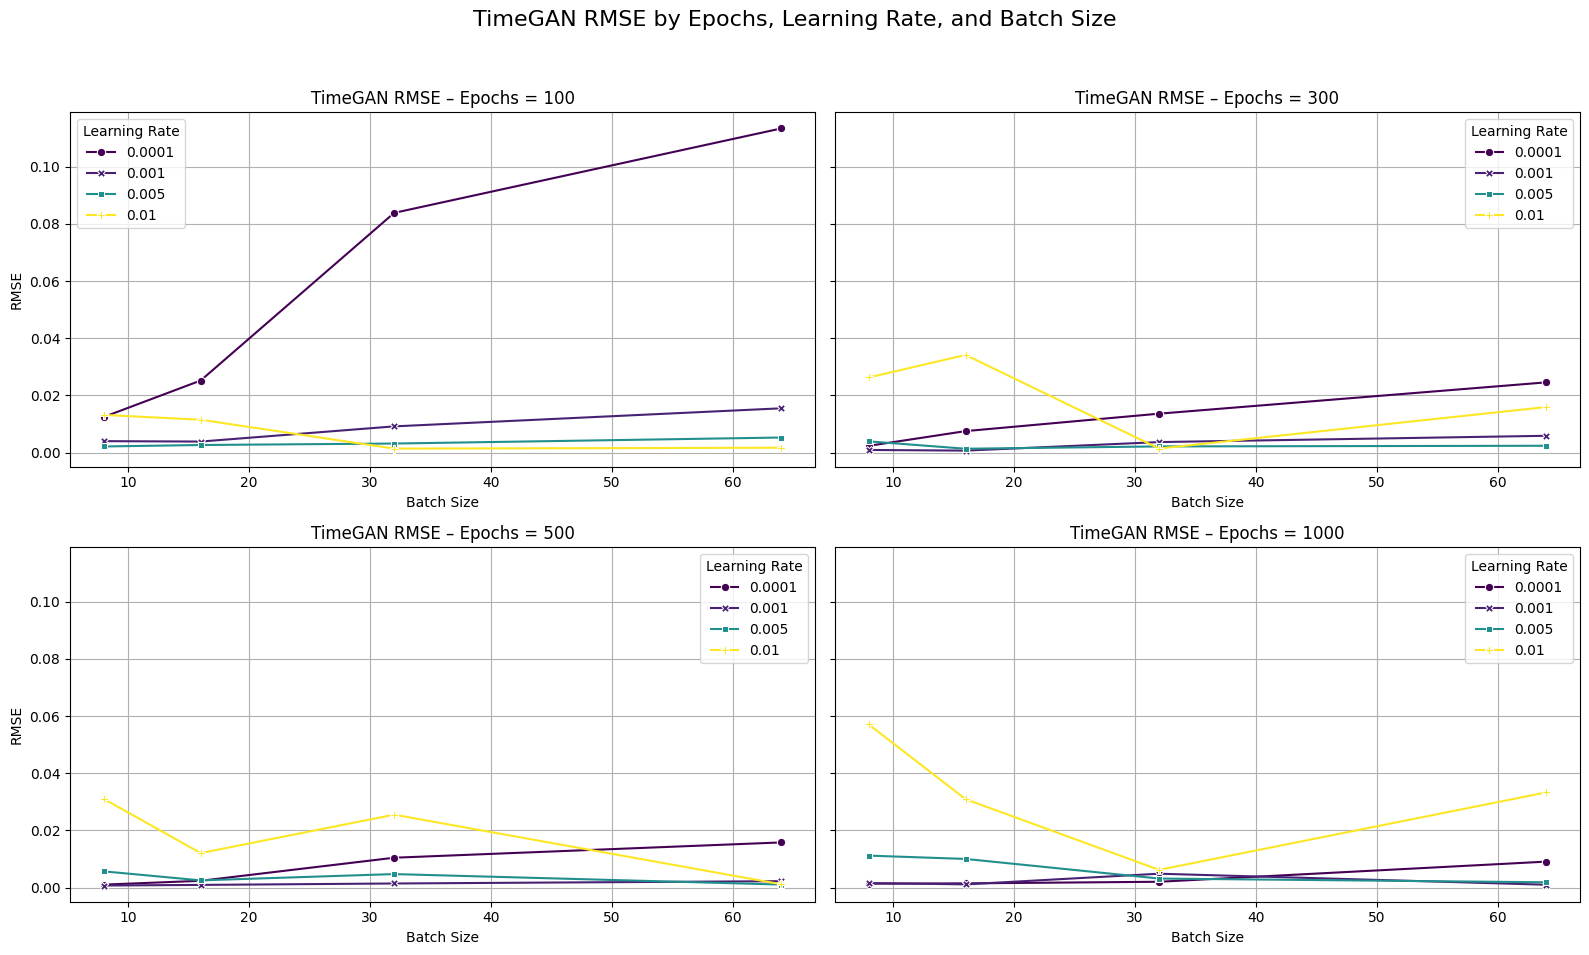

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort and group
df_rmse_timegan_sorted = df_rmse_timegan.sort_values(by=["Epochs", "BatchSize", "LR"])

# Epoch values
epochs_set = [100, 300, 500, 1000]

# Set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
axes = axes.flatten()

# Plot per epoch
for i, epoch in enumerate(epochs_set):
    subset = df_rmse_timegan_sorted[df_rmse_timegan_sorted["Epochs"] == epoch]
    sns.lineplot(
        data=subset,
        x="BatchSize",
        y="RMSE",
        hue="LR",
        style="LR",
        markers=True,
        dashes=False,
        ax=axes[i],
        palette="viridis"
    )
    axes[i].set_title(f"TimeGAN RMSE – Epochs = {epoch}")
    axes[i].set_xlabel("Batch Size")
    axes[i].set_ylabel("RMSE")
    axes[i].grid(True)
    axes[i].legend(title="Learning Rate")

plt.suptitle("TimeGAN RMSE by Epochs, Learning Rate, and Batch Size", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()